# 12.1 Finite Element Methods <a class="tocSkip">
Lecture 12.1  
Matt Piggott

## Table of Contents
```{contents}
```

## Learning objectives <a class="tocSkip">
    

- To introduce the finite element method
    
    
- To review how basis functions can be used to approximate functions, 
    
    
- and in turn how this idea can be used to ***project*** functions, as well as to ***solve*** differential equations 
    
    
- To understand how different types of BCs can be dealt with in the FEM


- To understand the local ***assembly*** process which is the implementation approach that allows us to readily extend 1D FEM ideas to higher dimensions


<br>

<br>

I'll try to split the material up into three key topics

- Projection of a function (basically the FEM without the need to deal with any derivatives)

- Solution of a BVP (the introduction of derivatives w.r.t. a single independent variable)

- How local assembly can be used to achieve an implementation in code which readily extends things efficiently to complex tesselations of the domain in higher dimensions.

## Introductory comments <a class="tocSkip">
    
Note that there are numerous ways that the finite element method can be introduced and derived.  

A significant subset of these go about this task in a very abstract/mathematical way. 

Here we will take a more practical perspective, but be warned if you pick up a random textbook it may well go about things in a very different manner. Ultimately though we will end up at the same place.
       

In [1]:
%precision 6
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as si
import scipy.linalg as sl
import scipy.sparse as sp
import scipy.sparse.linalg as spla
# the following allows us to plot triangles indicating convergence order
from mpltools import annotation
# as we're in 2D we will be doing some 3D plotting
from mpl_toolkits.mplot3d import Axes3D
# and using some colormaps
from matplotlib import cm
from pprint import pprint

# some default font sizes for plots
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Dejavu Sans']

## Introduction: finite elements vs volumes vs differences

The finite element method can be interpreted in a way that sets it somewhat apart from finite difference and finite volume methods.

In any numerical method our aim is generally to replace or approximate something that is continuous (infinite dimensional) with something that is discrete (finite dimensional). We need to do this in order to allow us to find the approximation on a finite computer.

FD and FV methods sought to approximate derivatives or fluxes in the underlying equation in terms of discrete (i.e. discretised) solution information, i.e. it "discretised the underlying equation". 
In 1D in particularly FD and FV aren't that different conceptually and lead to similar and even identical discretisations. 

The finite element method however is a little different - it takes an approach that approximates/discretises the numerical *solution* (function) but then asks that this solves the *exact* differential equation problem (in a weak sense). 

It is this approach, which approximates the solution function and not the underlying equation, that is the reason that (a) the approach can (is often) explained in quite a theoretical way, and (b) many powerful/useful theoretical results on errors, stability etc can be obtained.

The exact solution to a differential equation is a continuous function. And this function lives in an infinite-dimensional space of all possible functions (that satisfy some appropriate constraints, e.g. on their smoothness) and which is defined everywhere in space and time (in the case of time-dependent PDEs).

To (attempt to) find the exact solution analytically we can take derivatives of candidate solution functions and look for the one which satisfies our underlying PDE.

What we want to do here is approximate (discretise) this complex continuous function in a way that it becomes finite-dimensional, but such that it is still differentiable and we are therefore able to ask that it still satisfies our exact problem (in an appropriate sense to be explained later).

Note the difference with FD methods where we look for discrete solution values which satisfy the discretised PDE at a series of distinct points where we have replaced the derivatives with finite difference approximations.

With FEM we will therefore arrive at a solution that is equally valid everywhere, rather than just at discrete points.

This may all sound a little abstract, but hopefully things will become clear as we work through examples.

Rather than diving straight into discretising a differential equation problem, we will start our discussion of the finite element method by first considering ways in which we can approximate/discretise a function (which we can think of as the exact solution to our differential equation).

## Approximating a function

## Piecewise-polynomials

One way to start a description of the finite element method is to consider how we can approximate functions.

Suppose we have a function $f(x)$ and approximate it using a finite number of basis functions:

$$f_h(x) = \sum_{i=0}^N \alpha_i \phi_i(x). $$


So $f_h(x)\approx f(x)$ where


- $\alpha_i$ for $i=0,\,\ldots, N$ are the finite number of *weights* we need to find. 


- $\phi_i(x)$ for $i=0,\,\ldots, N$ are a finite number of prescribed *basis functions*.


Note that while $f(x)$ is continuous and potentially very complex (e.g. cannot be defined simply in terms of a finite number of parameters), the approximation $f_h(x)$ is effectively finite-dimensional as it is completely described by the $N+1$ weights (we assume the basis functions are chosen/given in advance). 

Importantly, and different to the numerical solutions obtained with FD methods, the approximation $f_h(x)$ is defined for all values of $x$,  and we can take its true derivatives that will also be defined everywhere (i.e. not need to use finite difference approximations of derivatives as we would with the FD method).

<br>

With this form of approximation there are actually a huge number of possibilities for us to proceed.

Firstly note that we haven't said anything about the nature of the basis functions $\phi_i(x)$. 

One option is for these to be so-called *global* functions, in that they are defined for all $x$ and are potentially non-zero across the total range of $x$ values, e.g. this would be the case with Fourier series approximations (or in the numerical solution of differential equations this would lead us to so-called [*spectral methods*](https://en.wikipedia.org/wiki/Spectral_method)).

However, an important aspect of the finite element method is that these basis functions are chosen to have *finite support*, i.e. they are only non-zero over a limited range of $x$ values (we will see below that this is a property we seek in order to ultimately arrive at a point where we need to solve linear systems involving *sparse* rather than dense matrices).

In addition, we look for basis functions which are easy to integrate.  The finite element method generally makes use of piecewise polynomial basis functions, which leads to our approximation $f_h(x)$ being a piecewise polynomial.

## An example

To help clarify these ideas let's consider a continuous and relatively complex function:

$$ f(x) = \sin(2\pi x) + \frac{3}{10}\cos(6\pi x^2).$$

First let's plot this over the interval $[0,1]$.

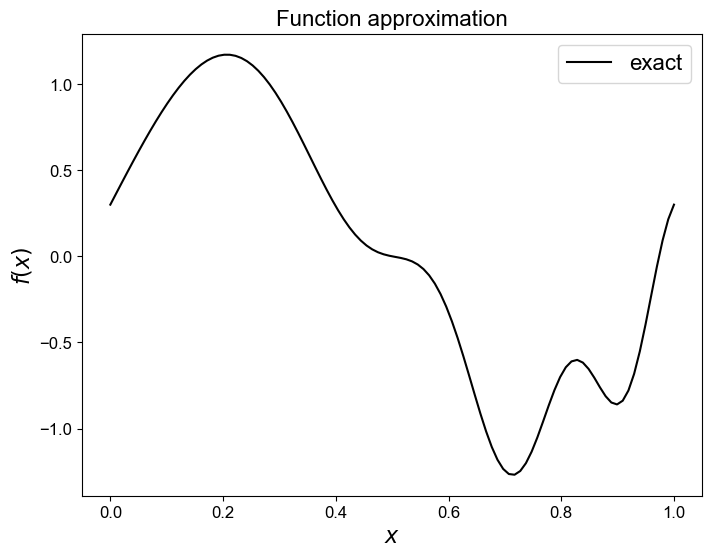

In [2]:
def f(x):
    return np.sin(2*np.pi*x) + 0.3*np.cos(3.*2.*np.pi*x**2)

x_fine = np.linspace(0. ,1. ,100)

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$f(x)$', fontsize=16)
ax1.set_title('Function approximation', fontsize=16)
ax1.plot(x_fine, f(x_fine), 'k-', label = 'exact')
ax1.legend(loc='best', fontsize=16);

## Interpolation of a function (Lagrange polynomial - a reminder)

Perhaps the obvious way to approximate this with a sum over piecewise polynomials is to construct the piecewise linear interpolant, as we did in the lectures on interpolation.

We take a finite number of sample points (we assume 4 evenly distributed points in the examples below), and then for every pair of these find the linear polynomial that passes through or joins them.

We made the point in L1 that this is what you get if you plot the discrete data using default plotting options, but let's remind ourselves how we can use `numpy.polyfit` to find the linear polynomial approximation in between each pair of sample points.

For each pair of points this will provide an infinite line - we only want to use each line between each appropraite pair of points:

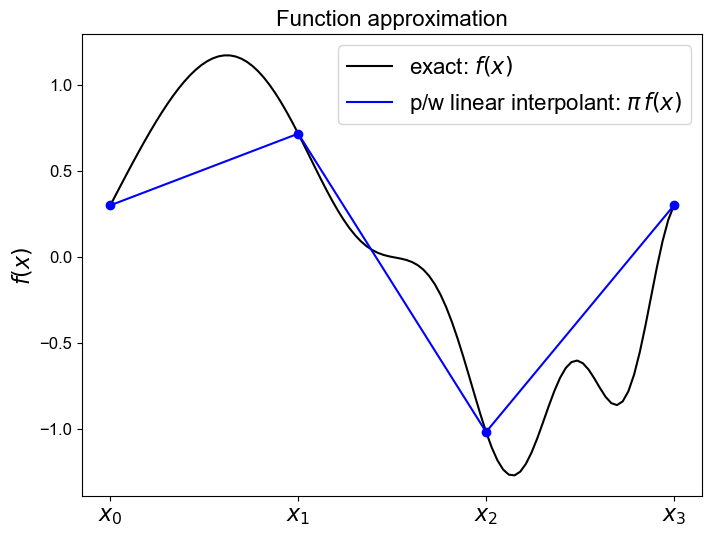

In [3]:
# discrete data
N_nodes = 4
# if we have 4 nodes, including at the ends of our domain, then we have 4-1=3 elements/cells
N_elements = N_nodes - 1
# and the element size is the total interval length divided by the number of elements
dx = 1./N_elements
# construct the node locations
x_nodes = np.linspace(0., 1., N_nodes)
# and evaluate our example function f(.) at these points
y_nodes = f(x_nodes)
# define a much finer mesh for plotting purposes
x_fine = np.linspace(0. ,1. ,100)

# initialise the value of our interpolant at x_fine to zero 
# [see interpolation lecture for a similar p/w quadratic example we considered]
P1 = np.zeros_like(x_fine)
# loop over each pair of data points 
for i in range(0, N_elements):
    # use polyfit to construct a linear polynomial fit to the data at nodes i and i+1
    P1_loc = np.polyfit(x_nodes[i:i + 2], y_nodes[i:i +2], 1)
    # use polyval to evaluate P1_loc at the x_fine values, 
    # but only for those values in the local interval [x_{i},x_{i+1}]
    P1 += np.polyval(P1_loc, x_fine) * (x_fine >= x_nodes[i]) * (x_fine <= x_nodes[i + 1])

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
#ax1.set_xlabel('$x$', fontsize=16)
ax1.set_xticks((x_nodes[0],x_nodes[1],x_nodes[2],x_nodes[3]))
ax1.set_xticklabels(('$x_0$','$x_1$','$x_2$','$x_3$', ), fontsize=16)
ax1.set_ylabel('$f(x)$', fontsize=16)
ax1.set_title('Function approximation', fontsize=16)
# plot the exact function on a fine mesh
ax1.plot(x_fine, f(x_fine), 'k-', label = 'exact: $f(x)$')
# plot the p/w linear interpolant on a coarse mesh
ax1.plot(x_fine, P1, 'b', label='p/w linear interpolant: $\pi\,f(x)$')
ax1.plot(x_nodes, f(x_nodes), 'bo')
ax1.legend(loc='best', fontsize=16);

### Comments

NB. a common notation for an *interpolant* of a function $f$, is the function $\pi f$ - think of $\pi$ as an operator that turns a function $f$ into its interpolant.


- Recall that an interpolant passes through the underlying function (or rather discrete data obtained from evaluating the function) exactly at the data points: $\pi f(x_i)=f(x_i)$ $\forall i$.


- We see this in the plot above with the blue dots.


- But we will see below that this is *not* the only option available to us.

## Interpolation errors

### Norms

Note that unless our function itself is linear, a linear interpolant will have errors in between the data points (where the approximation is by definition exact).

The difference

$$ f - \pi f,$$

which is itself is a function of $x$, is called the *interpolation error*.

To judge if it is large or small we need a norm to turn it into a single number, i.e. we need to compute $\,\| f - \pi f \|$.

The $L^2$ norm is often used for this purpose as it says something about the size of a function.

For a general function $v$, the $L^2$ norm over a domain $I$ is defined as

$$\|v\|_{L^2(I)} = \left( \int_I\, v^2\, dx\right)^{1/2},$$


where $I$ might be our entire domain, or a single sub-interval/element.


### Error bounds formulae  [$\star$]
```{admonition} Optional Content
:class: dropdown
We will state the following standard results without proving them.

Over a single element $e_i$ we have the (linear) interpolation error bound

$$\| f - \pi f\|_{L^2(e_i)} \leq C \, \Delta x_i^2 \, ||f''||_{L^2(e_i)}, $$

where $C$ is a constant,
$e_i := [x_i,x_{i+1}]$ and $\Delta x_i = x_{i+1} - x_{i}$ (we're assuming we're in 1D here).


We can sum up this result over our entire domain:


$$ \| f - \pi f\|_{L^2(I)} \leq C \sum_{i=0}^N \Delta x_i^2 \, ||f''||_{L^2(e_i)}.$$
```

### Comments

- This is consistent with what we've seen before with Taylor series analysis in previous lectures - the error is zero for a p/w linear interpolant if $f$ is linear (as the second derivative is zero), and is larger for a larger mesh spacing or a more complex function. The error converges at second order with mesh spacing.


- It turns our that while being exact at the nodes, when considered in terms of the $L^2$ (and other) norm we can do better


- and remember we want/have a solution equally valid everywhere so we need to consider its quality away from the nodes as well.

## Basis functions [reminder from a previous lecture]

To progress we need to introduce basis functions, which are a critical component of the finite element method.

So far we have considered a piecewise linear approximation to our function. 

But how can we write this as an expansion of the form from earlier:

$$f_h(x) = \sum_{j=0}^N \alpha_j \phi_j(x), $$

and what are the basis functions $\phi_j(x)$ here?

[Why am I using $j$ here for the sum rather than the more obvious $i$ (they're *dummy indices* so it of course doesn't actually matter which I use) - we will see why later.]

## Hat functions

If you think about it the answer is the following

$$
\phi_i(x) = 
\begin{cases}
\frac{x - x_{i-1}}{\Delta x_{i-1}}, &\text{if}\;\;\; x\in e_{i-1}\equiv[x_{i-1},x_{i}] \\[5pt]
\frac{x_{i+1} - x}{\Delta x_{i}}, &\text{if}\;\;\; x\in e_{i}\equiv[x_{i},x_{i+1}] \\[5pt]
0, & \text{otherwise} \\
\end{cases}
$$

which have the name hat (or chapeau) functions, and look like the following.


```{figure} Figures/fem_basis_functions.svg
:width: 75%
```


## Support of basis functions

An important aspect of the finite element method is appreciating when the basis functions and the products of basis functions, e.g.

$$\phi_i \, \phi_j\,,$$

are non-zero.

We call the area a function is non-zero its *support*, and with the FEM we are looking for this area to be finite and for each basis function for this to be confined to a small portion of the overall domain - the mathematical term is [*compact support*](https://mathworld.wolfram.com/CompactSupport.html).

For a given value of $\,i$, based upon the above schematic for what values of $\,j\,$ is the product non-zero anywhere (alternatively, for what choices of $j$, given $i$, is the product zero everywhere?).

Similarly note that the derivative of a basis function $\,\phi_{i,x}\,$, has the same (finite) support as $\,\phi_i\,$ and hence the same result holds for the products

$$\phi_{i}\,\phi_{j,x}\,, \;\;\;\;\; \phi'_{i}\,\phi_{j}\,,\;\;\;\;\;\text{and}\;\;\;\; \phi'_{i}\,\phi'_{j}\,,$$

where the subscript "comma $x$" and the primes in the line above are just notation to indicate the $x$ derivatives of the basis functions.

## Some code to return the hat/basis functions

First let's implement a function that returns the $i$-th hat function on a mesh.  You can try playing with the value for $i$ and seeing how it changes the plot.

Second we show how we can make use of these basis functions to implement a function returning $f_h(x)$ for given weights.

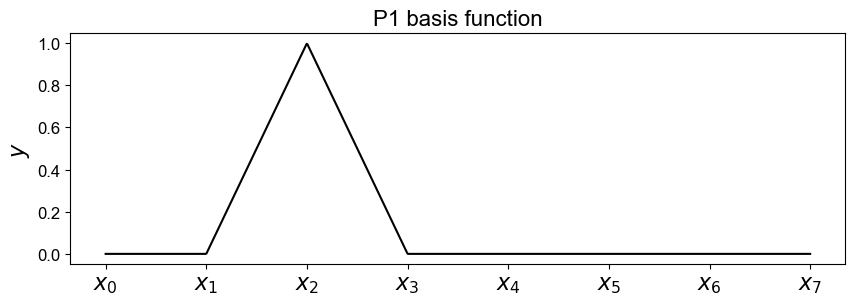

In [4]:
def hat_function(i, x_nodes):
    """ Linear continuous basis function at node i.
    Returns a function for later use in quadrature rules.
    """
    assert(i>=0 and i<=len(x_nodes)-1)
    dx = np.diff(x_nodes)
    if i==0:
        hat = lambda x: np.select([ x<=x_nodes[i+1] ], [ (x_nodes[i+1] - x)/dx[i] ] ,0.0)
    elif i==len(x_nodes)-1:
        hat = lambda x: np.select([ x>=x_nodes[i-1] ], [ (x - x_nodes[i-1])/dx[i-1] ] ,0.0)
    else:
        hat = lambda x: np.select(
                [ np.all([[x>=x_nodes[i-1]],[x<=x_nodes[i]]], axis=0)[0],  
                  np.all([[x>=x_nodes[i]],[x<=x_nodes[i+1]]], axis=0)[0]] ,
                [ (x-x_nodes[i-1])/dx[i-1], (x_nodes[i+1]-x)/dx[i] ] ,0.0)
    return hat

# let's plot what this function returns
# first set up the nodes, a fine mesh to use to plot and the axes
x_nodes = np.linspace(0,1,8)
x_fine = np.linspace(0,1,1000)
fig = plt.figure(figsize=(10, 3))
ax1 = fig.add_subplot(111)
ax1.set_xticks((x_nodes))
ax1.set_xticklabels(('$x_0$','$x_1$','$x_2$','$x_3$','$x_4$','$x_5$','$x_6$','$x_7$' ), fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
ax1.set_title('P1 basis function', fontsize=16)

# you can change the following to be in [0,n] to change what the 
# function returns for a given node number
node = 2
phi = hat_function(node, x_nodes)
# it's returned a function phi, so just evaluate this on the mesh
ax1.plot(x_fine, phi(x_fine), 'k-');

Now use this function which returns the "basis functions" to construct the piecewise linear function $f_h(x)$, where the required weights are just given by the function $f$ evaluates at the node locations (`y_nodes = f(x_nodes)`).

In this implementation our function returns the values of $f_h(x)$ at a prescribed array of $x$ locations.

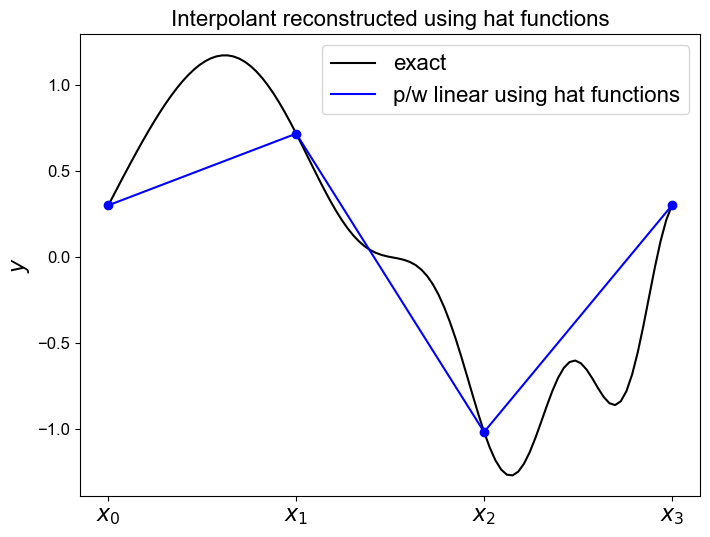

In [5]:
# discrete data
N_nodes = 4
# if we have 4 nodes, including at the ends of our domain, then we have 4-1=3 elements/cells
N_elements = N_nodes - 1
# and the element size is the total interval length divided by the number of elements
dx = 1./N_elements
# construct the node locations
x_nodes = np.linspace(0., 1., N_nodes)

# and evaluate our function at these points - these will be our weights
y_nodes = f(x_nodes)

# now a function to reconstruct the p/w linear function
def pwlinear(x_nodes, y_nodes, x):
    """Function to return f_h(x) at locations given in x, 
    with top hat functions on a mesh given by x_nodes, and
    corresponding weights given in y_nodes.
    """
    val = np.zeros_like(x)
    # loop over x values, equivalently the basis functions
    for i in range(len(x)):
        # which mesh node is directly to the left of x[i] ?
        node = np.where( x[i] >= x_nodes )[0][-1]
        # because of the greater than or equals above, deal with problem of hitting last node
        node = np.minimum(len(x_nodes)-2,node)
        # add together the contributions from the two hat functions at this x location - 
        # the hat functions centred on "node" (to the left)
        phi_node = hat_function(node, x_nodes)
        # and "node+1" (to the right)
        phi_node_plus_1 = hat_function(node+1, x_nodes)
        # now take the weighted sum of these two hat functions
        val[i] = y_nodes[node]*phi_node(x[i]) + y_nodes[node+1]*phi_node_plus_1(x[i])
    return val

x_fine = np.linspace(0,1,100)
f_h = pwlinear(x_nodes, y_nodes, x_fine)

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
#ax1.set_xlabel('$x$', fontsize=16)
ax1.set_xticks((x_nodes[0],x_nodes[1],x_nodes[2],x_nodes[3]))
ax1.set_xticklabels(('$x_0$','$x_1$','$x_2$','$x_3$', ), fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
ax1.set_title('Interpolant reconstructed using hat functions', fontsize=16)
ax1.plot(x_fine, f(x_fine), 'k-', label = 'exact')
ax1.plot(x_fine, f_h, 'b-', label = 'p/w linear using hat functions')
ax1.plot(x_nodes, f(x_nodes), 'bo')
ax1.legend(loc='best', fontsize=16);

So as expected the expansion of these hat (basis) functions goes through the values given by the weights, with straight lines in between.

## Unstructured mesh data structures

[Note we'll return to this topic in more detail when discussing local assembly].

The following image presents a schematic of an unstructured mesh data structure, or connectivity, in the simple 1D case and assuming that we have two nodes per element, and that these are located at the ends of the elements (other more complex choices are possible!)

```{figure} Figures/connectivity_1d.svg
:width: 75%
```

- Blue are the *element numbers*


- Red are the *local node numbers*


- Black are the *global node numbers*


The connectivity can be described by the so-called connectivity matrix, which again in 1D takes the particularly simple form

$$
\begin{pmatrix}
    0 & 1 & \ldots & i-1 & i   & i+1 & \ldots & n \\
    1 & 2 & \ldots & i   & i+1 & i+2 & \ldots & n+1
\end{pmatrix}
$$

the column being the element, the row the local node number, and the entry of the matrix then being the global node number.

The size of the connectivity matrix is therefore: 

$$\text{the number of local nodes per element}\;\;\times\;\;\text{the number of elements}.$$

### Terminology


- *element*, cell, "finite volume" essentially mean the same thing - discrete objects used to cover or *tessellate* the entire domain


- *vertices* are the geometrical objects used to define the elements, e.g. the two end points of each sub-interval in 1D,  3 corners of a triangle etc.


- *nodes* are the locations where our unknowns (that we will be solving for) are located, in the early stages of our discussions nodes$\equiv$vertices, but this won't always be the case 


- a simple example would be to have three nodes within each interval (at each end and one in the middle) and use these with a quadratic basis function, but only two of them required as the vertices defining the cell. More complex basis functions won't co-locate any of the nodes with the vertices!

## $L^2$ projection of a function

Of course interpolation is not the only way to approximate a function.

Indeed interpolation is really developed primarily for the use case where we are given finite $(x,y)$ data, and we don't have enough information to do anything other than pass through these values as well as possible.

In the case here (projection) we actually have access to the underlying function and so we should be able to do better than what we obtain with interpolation.

To do better with the same number of free parameters (i.e. on the same finite mesh and assuming the same basis functions) we need to relax the assumption that the finite-dimensional approximation passes through the actual function values at the nodes of the mesh.

Basically, we have a set of basis functions $,\phi_i(x)$, $\,i=0,1,\ldots,N$, which through their linear combinations 
define a space $V_h$ - which here is clearly the space of all piecewise-linear continuous functions. 

That is $v\in V_h$ if and only if we can write

$$v(x) \equiv \sum_{j=0}^N \alpha_j \phi_j(x),$$

for some combination of weights $\alpha_j$.

We want to find the function in this space which minimises the error.  The interpolant $\,\pi f\,$ is clearly ***a*** member of this space, but as we shall see not necessarily the best solution for us.

## Theory

So we want to

$$\text{find} \;\;\;v\in V_h\;\;\; \text{which minimises }
\;\;\;\; \| f - v\|^2_{L^2(I)} .$$

It turns out that as we ask the question in terms of the $L^2$ norm, the answer we are looking for is the function $\,v=P_h\,f\,$ where $P_h$ stands for the so-called ***$L^2$ projection*** of the function $f$ - think if it as anther operator like $\pi$ but potentially giving a different answer.

The $L^2$ projection $P_h\,f$, which is a function in $V_h$, is uniquely defined by that property that

$$ \int_I \,(f - P_h\,f )\,v\,dx = 0,\;\;\;\; \forall \; v\in V_h.$$


<br> 

What is this telling us?


1. This means that the error or the residual $(f - P_h\,f)$ is [***orthogonal***](https://en.wikipedia.org/wiki/Orthogonal_functions) to every function in $V_h$. 


2. This in turn means that the $P_h\,f$ we obtain is the closest function *within* $V_h$ to $f$.


3. This means that in the case that $f\in V_h$, i.e. if $f$ is itself p/w linear, then our result is exact: $P_h\,f\equiv f$.

### Finite-dimensional example

Visually, pretend that $V_h$ is represented by a straight line in 2D space, and we want to find the point on the line closest to an arbitrary point anywhere in 2D - sketch this case.


## Theory - continued

How does us satisfying the above constraints "uniquely define" $P_h\,f$? 

Well notice that $\,P_h\,f = \sum_{j=0}^N \alpha_j \phi_j(x)\,$ has $N+1$ free parameters, and the requirement that the above integral is zero for all $v\in V_h$ actually yields us $N+1$ pieces of information, as $V_h$ also has dimension $n+1$.

So we have $N+1$ unknowns and $N+1$ equations and we know that we can in principle solve this system uniquely.

Specifically, by linearity this requirement is completely equivalent to requiring orthogonality to the individual basis functions:

$$ \int_I \,(f - P_h\,f )\,\phi_i\,dx = 0,\;\;\;\; i=0,1,\ldots N.$$

So what do we have?

For $i=0,1,\ldots n$ we want the following to be true

$$
\begin{align*}
\int_I \,(f - P_h\,f )\,\phi_i\,dx  &= 0 \\[10pt]
\iff  \int_I \, (P_h\,f) \,\phi_i\,dx &=  \int_I \,f \,\phi_i\,dx\\[10pt]
\iff \int_I \,\sum_{j=0}^n \alpha_j \phi_j \,\phi_i\,dx &=  \int_I \,f \,\phi_i\,dx\\[10pt]
\iff \sum_{j=0}^N \alpha_j  \int_I \,\phi_j \,\phi_i\,dx &=  \int_I \,f \,\phi_i\,dx\\[10pt]
\iff \sum_{j=0}^N \alpha_j  M_{ij} &=  \int_I \,f \,\phi_i\,dx\\[10pt]
\iff    M\,\boldsymbol{\alpha} &=  \boldsymbol{RHS},
\end{align*}
$$

where $M$ is the so-called *mass matrix*, $\boldsymbol{\alpha}$ is the vector of unknown weights ${\alpha}_j$, and the RHS vector has the entries $\int_I \,f \,\phi_i\,dx$.

For historical reasons the RHS is sometimes called the *load* vector.

We need to compute the mass matrix and the load vector, solve the linear system for the weights $\boldsymbol{\alpha}$ and we have our $L^2$ projection.

Note that we introduced notation for our solution to this (projection) problem at the start of this discussion: $\,P_h\,f\,$.

Alternatively we could have posed the problem as find $v_h\in V_h$ such that $v=f$ in a weak sense,
i.e.

$$ \int_I \,(f - v_h )\,\phi_i\,dx = 0,\;\;\;\; i=0,1,\ldots N,$$

and since we can write $v_h = \sum_{j=0}^N \alpha_j \phi_j(x)\,$, this leads to exactly the same result as in the previous cell.

<br>

The point I'm making here is to emphasise that we solved the *equation* $v=f$, using the "finite element method" (which invovles discretising $v$ and utilising the weak form of the equation).

## Link to the finite element method

This is basically the crux of the finite element method, but when solving a **differential equation** instead of starting from the **equation**  $\,v = f\,$ and going through the above $L^2$ projection procedure to find the best approximation (which we know to be $\,v=P_h\,f$) from within the function space our basis functions span, we instead start from our *differential equation* and consider the weak form of that. 

In the case of a differential equation we shall see that we get different, or additional, matrices on the LHS, and we also need to deal with boundary conditions. We will see plenty of examples in the context of BVPs and PDEs.

## Implementation - the mass matrix


Define the mass matrix to be the matrix $M$ with entries

$$ M_{ij} = \int_\Omega \,\phi_i(x)\,\phi_j(x)\,  dx. $$

[NB. Note that if the basis functions where what is called orthogonal functions then the mass matrix would be diagonal.]

In our case we choose basis functions with finite support - what does this mean?

Well if we consider the form of our top hat function, for a given row, i.e. a given value of $i$, then the integrand will be zero for all $j$ values other than $j=i$, and $j=i\pm 1$, i.e. the mass matrix is tridiagonal.

<br>

Remembering that

$$
\phi_i(x) = 
\begin{cases}
\frac{x - x_{i-1}}{\Delta x_{i-1}}, &\text{if}\;\;\; x\in e_{i-1}\equiv[x_{i-1},x_{i}] \\[5pt]
\frac{x_{i+1} - x}{\Delta x_{i}}, &\text{if}\;\;\; x\in e_{i}\equiv[x_{i},x_{i+1}] \\[5pt]
0, & \text{otherwise} \\
\end{cases}
$$

<br>


In the case $j=i$ we can compute the diagonal entry of the mass matrix:

$$
\begin{align*}
M_{ii} &= \int_\Omega \,\phi_i(x)\,\phi_j(x)\,  dx\\[5pt]
& = \int_{x_{i-1}}^{x_{i+1}} \,\phi_i(x)\,\phi_i(x)\,  dx\\[5pt]
& = \int_{x_{i-1}}^{x_{i}} \,\phi_i(x)\,\phi_i(x)\,  dx + \int_{x_{i}}^{x_{i+1}} \,\phi_i(x)\,\phi_i(x)\,  dx\\[5pt]
& = \int_{x_{i-1}}^{x_{i}} \,\frac{x - x_{i-1}}{\Delta x_{i-1}}\,\frac{x - x_{i-1}}{\Delta x_{i-1}}\,  dx + \int_{x_{i}}^{x_{i+1}} \,\frac{x_{i+1} - x}{\Delta x_{i}}\,\frac{x_{i+1} - x}{\Delta x_{i}}\,  dx\\[5pt]
& = \frac{1}{\Delta x_{i-1}^2} \int_{0}^{\Delta x_{i-1}} \,s^2\,  ds + \frac{1}{\Delta x_{i}^2}\int_{0}^{\Delta x_{i}} \, (\Delta x_{i} - t)^2\,  dt\\
& \qquad \qquad (\text{where}\;\;\; s:=x - x_{i-1},\;\;\;
t:=x - x_i\implies x_{i+1} - x = \Delta x_{i} -t)\\[5pt]
& = \frac{\Delta x_{i-1}}{3} + \frac{\Delta x_{i}}{3}.
\end{align*}
$$

Similarly,

$$
\begin{align*}
M_{i,i-1}
& = \int_{x_{i-1}}^{x_{i+1}} \,\phi_i(x)\,\phi_{i-1}(x)\,  dx\\[5pt]
& = \int_{x_{i-1}}^{x_{i}} \,\phi_i(x)\,\phi_{i-1}(x)\,  dx + \int_{x_{i}}^{x_{i+1}} \,\phi_{i-1}(x)\,\phi_i(x)\,  dx\;\;\;\;\;\;(\text{the second term here is zero!})\\[5pt]
& = \int_{x_{i-1}}^{x_{i}} \,\phi_i(x)\,\phi_{i-1}(x)\,  dx \\[5pt]
& = \int_{x_{i-1}}^{x_{i}} \, \frac{x - x_{i-1}}{\Delta x_{i-1}}\,\frac{x_i - x}{\Delta x_{i-1}}\,  dx \\[5pt]
& = \frac{1}{\Delta x_{i-1}^2} \int_{0}^{\Delta x_{i-1}} \,s(x_i - (s+x_{i-1})\,  ds 
\;\;\;\;\;\;(\text{where}\;\;\; s:=x - x_{i-1})\\[5pt]
& = \frac{1}{\Delta x_{i-1}^2} \int_{0}^{\Delta x_{i-1}} \,s(\Delta x_{i-1} - s)\,  ds \\[5pt]
& = \frac{1}{\Delta x_{i-1}^2} \left[\frac{s^2}{2}\Delta x_{i-1} - \frac{s^3}{3} \right]_{0}^{\Delta x_{i-1}}  \\[5pt]
& = \frac{\Delta x_{i-1}}{6},
\end{align*}
$$

and

$$
\begin{align*}
M_{i,i+1} = \ldots =  \frac{\Delta x_{i}}{6}.
\end{align*}
$$

Therefore one internal row (the $i$-th row) of the tridiagonal mass matrix has the entries

$$\left[0 \;\;\;\;\; \cdots \;\;\;\;\; 0 \;\;\;\;\; \frac{\Delta x_{i-1}}{6} \;\;\;\;\;  \frac{\Delta x_{i-1}}{3} + \frac{\Delta x_{i}}{3}  \;\;\;\;\; \frac{\Delta x_{i}}{6} \;\;\;\;\; 0 \;\;\;\;\; \cdots \;\;\;\;\;  0  \right]. $$

For the top and bottom rows of the matrix the diagonal entries are halved as these correspond to the basis functions at the ends of the domain which only have half the support, i.e. the top left entry of the matrix is $\frac{\Delta x_{0}}{3}$ and the bottom right $\frac{\Delta x_{N}}{3}$.

Notice that this matrix is symmetric, as should be clear from its definition:

$$ M_{ij} = \int_\Omega \,\phi_i(x)\,\phi_j(x)\,  dx, $$

<br>

$M_{ij}$ is obviously the same as $M_{ji}$ as the integrals don't care in which order you multiply the basis functions] as well as the calculations we've just performed.

<br>

Note that the details of how to compute these integrals exactly aren't that important, as in practice we will make use of quadrature rules.

## Implementation in code

First let's construct the mass matrix explicitly "by hand" using our derivation of the entries above and assuming $\Delta x$ is constant.

In [6]:
# discrete data
N_nodes = 4
N_elements = N_nodes - 1
dx = 1. # for simplicity

# construct mass matrix
Mass_CG = 4. * np.diag(np.ones(N_nodes),0) +  np.diag(np.ones(N_nodes-1),-1) +  np.diag(np.ones(N_nodes-1),1)
Mass_CG[0,0] = 2. 
Mass_CG[-1,-1] = 2.
Mass_CG = Mass_CG * (dx / 6.)
pprint(Mass_CG)

array([[0.33333333, 0.16666667, 0.        , 0.        ],
       [0.16666667, 0.66666667, 0.16666667, 0.        ],
       [0.        , 0.16666667, 0.66666667, 0.16666667],
       [0.        , 0.        , 0.16666667, 0.33333333]])


Now let's write a function to do this for use later.

In [7]:
def mass_matrix(x):
    dx = np.diff(x)
    M = np.zeros((len(x), len(x)))
    M[1:-1,1:-1] = np.diag(dx[:-1]/3  +  dx[1:]/3 , k=0) 
    M += np.diag(dx/6   , k=-1) + np.diag(dx/6   , k=1)
    M[0,0] = dx[0]/3
    M[-1,-1] = dx[-1]/3
    return M

pprint(mass_matrix(np.linspace(0,3,4)))

array([[0.33333333, 0.16666667, 0.        , 0.        ],
       [0.16666667, 0.66666667, 0.16666667, 0.        ],
       [0.        , 0.16666667, 0.66666667, 0.16666667],
       [0.        , 0.        , 0.16666667, 0.33333333]])


## Quadrature

While we can compute these integrals of basis functions exactly (at least in this simple case - see later material on "assembly" for the general way to do this), we are going to need to perform numerical integration in order to compute other more complex integrals.

Of course we could use SciPy here, but let's use our own implementation.

In [8]:
# use the composite version of simpsons rule for this part since we will be
# integrating over a relatively large number of points below

def simpsons_composite_rule(a, b, function, number_intervals=10):
    """Function to evaluate the composite Simpson's rule only using
    function evaluations at (number_intervals + 1) points.
    
    This implementation requires that the number of subintervals (number_intervals) be even
    """
    assert number_intervals % 2 == 0, "number_intervals is not even"

    interval_size = (b - a) / number_intervals
    # start with the two end member values
    I_cS2 = function(a) + function(b)

    # add in those terms with a coefficient of 4
    for i in range(1, number_intervals, 2):
        I_cS2 += 4 * function(a + i * interval_size)

    # and those terms with a coefficient of 2
    for i in range(2, number_intervals-1, 2):
        I_cS2 += 2 * function(a + i * interval_size)

    return I_cS2 * (interval_size / 3.0)

Let's test this quadrature code, as well as our implementation of the code from near the start to evaluate the basis functions, by numerically computing the integrals which make up the mass matrix we did above exactly, i.e. let's compute

$$
\begin{align*}
M_{ii}  = \int_{x_{i-1}}^{x_{i+1}} \,\phi_i(x)\,\phi_i(x)\,  dx,
\end{align*}
$$

and

$$
\begin{align*}
M_{i,i+1} = \int_{x_{i-1}}^{x_{i+1}} \,\phi_i(x)\,\phi_{i+1}(x)\,  dx.
\end{align*}
$$

Let's consider the simple case $\Delta x_{i}=1,$  $\forall i$.  

From our analytical evaluation of the integrals above we know that we should obtain the values 2/3 and 1/6 respectively.  And in the case of the $(0,0)$ and $(n,n)$ entries of the matrix we should obtain half of the internal main diagonal values, i.e. here 1/3. 


### Application of Simpson's rule [$\star$]
```{admonition} Optional Content
:class: dropdown
We note that the integrands of the integrals we need to compute are quadratic over an element for our current case (the product of two linear functions), and so can be exactly integrated using Simpson's rule applied over those individual elements where it is non-zero.

Recall from a previous lecture that Simpson's quadrature rule was

$$ \int_a^b\,f(x)\,dx \approx \frac{(b-a)}{6}\left( f \left ( a\right ) + 4\,f \left ( \frac{a+b}{2}\right ) + f\left ( b\right )\right), $$

(and remember that it was actually exact for cubic polynomials).

This is what we will actually do in our codes, so let's check this is correct 

(the first step is to split the integral into two, over the two elements over which the product of basis functions is non-zero and on each of which the product is a quadratic function - we need to consider in two parts as we have different quadratics on each element for the diagonal entry)

$$
\begin{align*}
M_{ii}  
&= 
\int_{x_{i-1}}^{x_{i+1}} \,\phi_i(x)\,\phi_i(x)\,  dx\\[10pt]
& = 
\int_{x_{i-1}}^{x_{i}} \,\frac{x - x_{i-1}}{\Delta x_{i-1}}\,\frac{x - x_{i-1}}{\Delta x_{i-1}}\,  dx + \int_{x_{i}}^{x_{i+1}} \,\frac{x_i - x}{\Delta x_{i}}\,\frac{x_i - x}{\Delta x_{i}}\,  dx \\[10pt]
&\qquad \qquad \text{(in the next line we replace the integrals by a Simpsons "approximation", which we know will be exact here)}\\[10pt]
& = 
\frac{\Delta x_{i-1}}{6}
\left[
\left(\frac{x_{i-1} - x_{i-1}}{\Delta x_{i-1}}\right)^2 
+ 4\left(\frac{(x_{i-1}+x_{i})/2 - x_{i-1}}{\Delta x_{i-1}}\right)^2 
+ \left(\frac{x_{i} - x_{i-1}}{\Delta x_{i-1}}\right)^2
\right]
\\[5pt]
& \;\;\;\;\;\;\; \;\;\;\;\;\;\;  
+ 
\frac{\Delta x_{i}}{6}
\left[
\left(\frac{x_i - x_{i+1}}{\Delta x_{i}}\right)^2 
+ 4\left(\frac{x_i - (x_{i}+x_{i+1})/2}{\Delta x_{i}}\right)^2 
+ \left(\frac{x_i - x_{i+1}}{\Delta x_{i}}\right)^2\right] \\[10pt]
& = 
\frac{\Delta x_{i-1}}{6}
\left[
\left( 0 \right)^2 
+ 4\left(  \frac{ \frac{1}{2} \Delta x_{i-1}}{\Delta x_{i-1}} \right)^2 
+ \left(\frac{\Delta x_{i-1}}{\Delta x_{i-1}}\right)^2\right] \\[5pt]
& \;\;\;\;\;\;\; \;\;\;\;\;\;\;  
+ 
\frac{\Delta x_{i}}{6}
\left[
\left(\frac{-\Delta x_{i}}{\Delta x_{i}}\right)^2 
+ 4\left(\frac{ -\frac{1}{2} \Delta x_{i} }{\Delta x_{i}}\right)^2 
+ \left(0\right)^2 \right]
\\[10pt]
& = 
\frac{\Delta x_{i-1}}{6} \left[ 0 + 1 + 1 \right] + 
\frac{\Delta x_{i}}{6} \left[ 1 + 1 + 0 \right]
\\[10pt]
& = 
\frac{\Delta x_{i-1}}{3} + \frac{\Delta x_{i}}{3},
\end{align*}
$$

which agrees with the result we computed analytically above.  

We can similarly verify that the leading off-diagonal terms computed using Simpson's rule agree with what we calculated above, as well as the $0,0$ and $n,n$ entries.

This simply confirms that we get the exact result if we use Simpson's rule, i.e. although we perform numerical integration we do not introduce any errors in these particular operations of our algorithm (as we would if we used a quadrature scheme such as trapezoidal that only integrates linear polynomials exactly).

So if we use Simpson's rule we would be doing what is called *exact quadrature*. If we made the decision to use a lower precision rule (e.g. in an attempt to save computational cost), then we would be doing *inexact quadrature*.

[Note that it is absolutely possible to use higher order basis functions, e.g. quadratics, in which case we would need an appropriately quadrature rule if we wanted to compute the entries of the mass (and other discretisation terms) exactly].

In the calls to `simpsons_composite_rule` below I use 4 "intervals" when integrating over 2 elements (and 2 when integrating over 1) - why?

[Look at the docstring:

    `Function to evaluate the composite Simpson's rule only using
    function evaluations at (number_intervals + 1) points.`
]

```

In [9]:
# verify values in our mass matrix

# discrete data
dx = 1.
# dx being 1 means based on the above we should find entries [... 1/6, 2/3, 1/6, ...] 
# on internal rows,  and 1/3 on the top left and bottom right entries

N_nodes = 4
N_elements = N_nodes - 1

x_nodes = np.linspace(0, N_nodes-1 ,N_nodes)
y_nodes = f(x_nodes)

# an internal node
node = 1

phi_i = hat_function(node, x_nodes)
integrand = lambda x : phi_i(x) * phi_i(x)
print('The (i,i) value: ', simpsons_composite_rule(  x_nodes[node-1], x_nodes[node+1], integrand, 4 ))


phi_i = hat_function(node, x_nodes)
phi_i_plus_1 = hat_function(node+1, x_nodes)
integrand = lambda x : phi_i(x) * phi_i_plus_1(x)

print('The (i,i+1) value: ', simpsons_composite_rule(  x_nodes[node-1], x_nodes[node+1], integrand, 4 ))
# and emphasise that the first half of the interval contributes nothing 
# (integrate from x_nodes[node] instead of x_nodes[node-1] ... we get the same answer):
print('The (i,i+1) value (only integrate across single element): ', simpsons_composite_rule(x_nodes[node], x_nodes[node+1], integrand, 2 ))

# a boundary node
node = 0

phi_i = hat_function(node, x_nodes)
integrand = lambda x : phi_i(x) * phi_i(x)
print('The (0,0) value: ', simpsons_composite_rule( x_nodes[node], x_nodes[node+1], integrand, 2 ))

The (i,i) value:  0.6666666666666666
The (i,i+1) value:  0.16666666666666666
The (i,i+1) value (only integrate across single element):  0.16666666666666666
The (0,0) value:  0.3333333333333333


## Approximation using a continuous function

Now let's actually apply all of this to our simple test case. We need to form and solve

$$M\,\boldsymbol{\alpha} =  \boldsymbol{RHS},$$

where $M$ is the *mass matrix* which we now have a function to compute, and the RHS vector has the entries $\int_I \,f \,\phi_i\,dx$ which we have to compute for our given function $f$.

Let's do that now.

[Why did I say continuous in the title of this section?  Because there's an example in the homework where we still use p/w linear basis functions, but allow our approximating function to be discontinuous between elements!]

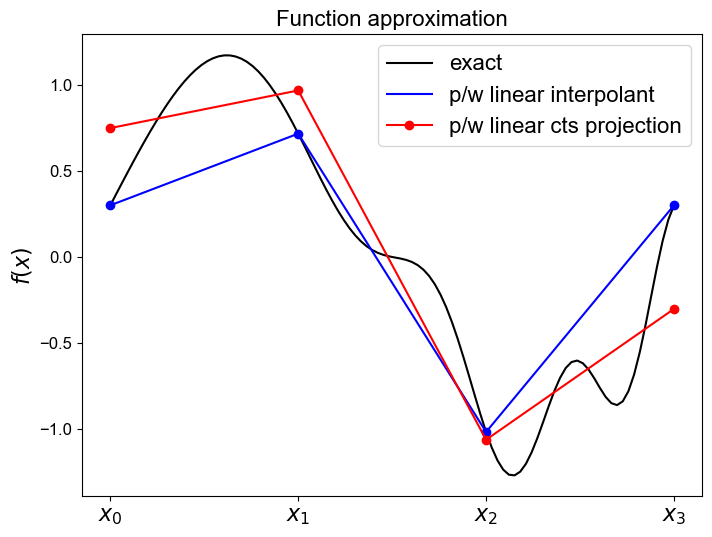

In [10]:
# our example function
def f(x):
    return np.sin(2*np.pi*x) + 0.3*np.cos(3.*2.*np.pi*x**2)

# discrete data
N_nodes = 4
N_elements = N_nodes - 1
dx = 1./N_elements
x_nodes = np.linspace(0,1,N_nodes)


# construct mass matrix
Mass_CG = mass_matrix(x_nodes)


# construct RHS vector - first initialise an array
RHS_CG = np.zeros(N_nodes)
# then do some quadrature
# loop over internal nodes
for node in range(1, N_nodes-1):
    # form the corresponding basis function
    phi_i = hat_function(node, x_nodes)
    # and the integrand we will integrate - our function multiplied by the 
    # corresponding basis function
    integrand = lambda x : f(x) * phi_i(x)
    RHS_CG[node] = simpsons_composite_rule(x_nodes[node-1], x_nodes[node+1], integrand, 100 )

# now consider the end nodes
node = 0
# integrate our function multiplied by the corresponding cts basis function
phi_i = hat_function(node, x_nodes)
integrand = lambda x : f(x) * phi_i(x)
RHS_CG[node] = simpsons_composite_rule(x_nodes[node], x_nodes[node+1], integrand, 100 )
node = N_nodes-1
phi_i = hat_function(node, x_nodes)
# integrate our function multiplied by the corresponding cts basis function
integrand = lambda x : f(x) * phi_i(x)
RHS_CG[node] = simpsons_composite_rule(x_nodes[node-1], x_nodes[node], integrand, 100 )

# solve our linear system
approx_CG = sl.solve(Mass_CG, RHS_CG)

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
#ax1.set_xlabel('$x$', fontsize=16)
ax1.set_xticks((x_nodes[0],x_nodes[1],x_nodes[2],x_nodes[3]))
ax1.set_xticklabels(('$x_0$','$x_1$','$x_2$','$x_3$', ), fontsize=16)
ax1.set_ylabel('$f(x)$', fontsize=16)
ax1.set_title('Function approximation', fontsize=16)
# plot the exact function on a fine mesh
x_fine = np.linspace(0., 1. ,100)
ax1.plot(x_fine, f(x_fine), 'k-', label = 'exact')
# plot the p/w linear interpolant on a coarse mesh - P1 computed in a cell above
ax1.plot(x_fine, P1, 'b', label='p/w linear interpolant')
ax1.plot(x_nodes, f(x_nodes), 'bo')
ax1.plot(x_nodes, approx_CG , 'ro-', label='p/w linear cts projection')
ax1.legend(loc='best', fontsize=16);

## Quality of approximation

Which of these is a better approximation?

Clearly the P1 interpolant if we ask the question of accuracy at the nodes only. 

But above we established that, by construction, our projection approach should yield a result that is optimal w.r.t. the $L^2$ norm, i.e. we cannot do any better when measuring agreement using this norm.

Let's check this - that the (CG) projection has lower errors than the interpolant when measured in the L2 norm (which we compute/approximate using the RMS error norm (see next cell) evaluated on a fine mesh upon which we evaluate the true function and the discrete approximation):

```{figure} Figures/P1vsCGvsDG_convergence.png
:width: 75%
```

What's the DG line? See homework and the image below:

```{figure} Figures/CG_DG_projection.png
:width: 75%
```

if we relax the requirement of continuity between elements (and so effectively have twice as many degrees of freedom to solve for) we can achieve an even better approximation.

## RMS (root mean square) vs $L^2$ norm [reminder from Comp Math]

Notice that I labeled the $y$ axes with RMS error rather than the $L^2$ norm. Why?

We want to compute

$$
\begin{align*} 
e  := \| f - P_h\, f\|^2_{L^2(I)}
= \left( \int_I\, \left[f - P_h\, f\right]^2\, dx\right)^{1/2}.
\end{align*}
$$

We can approximate the integral as

$$ \int_I\, \left[f(x) - (P_h\, f)(x)\right]^2\, dx 
\approx \sum_{i=1}^N  \, \left[f(s_i) - (P_h\, f)(s_i)\right]^2\,\Delta s.$$

I've introduced the variable $s$ here to emphasise that we want to evaluate the functions and their difference on a discrete mesh that is ideally finer than our finite element mesh, if we do this this will be an accurate approximation to the integral.

Now we note that (assuming our interval is of length 1) that

$$\Delta s = \frac{1}{N},$$

and finally we have

$$
\begin{align*} 
e_{L^2} & := \| f - P_h\, f\|^2_{L^2(I)}\\[10pt]
&= \left( \int_I\, \left[f - P_h\, f\right]^2\, dx\right)^{1/2}\\[10pt]
&\approx \left( \frac{1}{N} \sum_{i=1}^N  \, \left[f(s_i) - (P_h\, f)(s_i)\right]^2 \right)^{1/2}
\\[10pt]
&=: e_{\text{RMS}}.
\end{align*}
$$

Where if you look at the mathematical operations we perform here - the square **R**oot of the **M**ean of the **S**quares ... explains the name "RMS".


We can implement this in Python with something like

```Python
sl.norm(a - b) / np.sqrt(len(a))
```

where $a$ and $b$ are two vectors of discrete values. This is because the default norm is the Frobenius norm, which is what we need without having divided through by $N$. Since this norm has already taken the square root, we just need to divide through by the square root  of $N$.

Ultimately the RMS error (norm) is the appropriate discrete analogue of the $L^2$ norm.

But be careful with its use on a non-uniform mesh!

## Solving boundary value problems (BVPs) using the FEM

Recall that we considered BVPs in a previous lecture where we introduced them in the context of the steady state solution to a PDE.

As with the finite difference method, BVPs provide a useful way to explain spatial discretisation via the finite element method without needing to worry about variations in the time dimension.

## The fundamental form of the discretisation ignoring BCs

As we shall see below the details of the BCs we want to apply will change some of the discretisation details quite a lot, so initially we will explain things ignoring the BCs.

Our problem is to
find $u\equiv u(x)$ which satisfies the ODE over the interval $I=[0,1]$

$$-u'' = f,$$

for a given source term $\,f$ (subject to some BCs yet to be defined).

### Weak or variational form of problem

To progress with a FE discretisation we start from our continuous equation:

$$-u'' = f.$$

As we did with the $L^2$ projection of a function, we look for an approximation to the solution from within a finite-dimensional space of functions that is as close as possible to the true solution.

First we consider what the true continuous solution satisfies:

We look for a function $u\in V$ such that for all $v\in V$

$$\int_I \,-u''\,v\,dx = \int_I \,f\,v\,dx,$$

that is we satisfy the equation in a "weak sense".

It turns out that if we choose $V$ here to be the appropriate infinite-dimensional function space then this form of the problem *is equivalent* to the underlying differential equation.

We call the original equation the *strong form* of the problem, while we call the version where we have multiplied by $v$ and integrated the *weak* or the variational form of the problem.

### Discretisation by restricting the function space to be finite-dimensional

To discretise we simply replace the infinite-dimensional space $V$ with a finite-dimensional space $V_h$, e.g. the space of p/w linear functions we saw earlier!

This is what we mean by the finite element method approximating the solution function but not the underlying equation (or at least its weak form).

In practice we write the solution as 

$$u \approx u_h := \sum_{j=0}^N u_j \phi_j(x).$$

Previously when we were just projecting a given function this led to a discrete system with the mass matrix on the LHS. 

Now for an equation with derivatives this again leads to a discrete system, but with a *discretisation* matrix on the LHS rather than the simple mass matrix.

<br>

So now we have the discretised problem - find $u_h\in V_h$ (or equivalently find the weights $u_j$, $j=0,\ldots N$) such that:

$$\int_I \,-u_h''\,\phi_i\,dx = \int_I \,f\,\phi_i\,dx, \;\;\;\;\text{for}\;\;\;\; i=0,\ldots,N.$$


### Choice of basis functions (a.k.a. choice of function space a.k.a. choice of "finite element")

But now we're confronted with a problem - assuming that we've made the choice to use linear basis functions then our discrete solution $u_h$ is p/w linear, so the second derivative appearing in the above is zero everywhere and this equation doesn't make any sense.  

However, since we're asking for the weak (or variational or integral) form of the problem to be satisfied, we can perform [*integration by parts*](https://en.wikipedia.org/wiki/Integration_by_parts) and instead require that

$$\int_I \,u_h'\,\phi'_i\,dx - \int_{\partial I} u_h'\,\phi_i\,dx = \int_I \,f\,\phi_i\,dx, \;\;\;\;\text{for}\;\;\;\; i=0,\ldots,N.$$

Alternatively we could have considered quadratic (or higher) order basis functions and then we wouldn't have needed to integrate by parts (it would still have been *an option* for us, and as we shall see below we often make a decision to integrate by parts when we don't need to as it helps us to easily apply certain types of boundary conditions).

The topic of basis function (or finite element) choice is a massive research area where considerations of quantitative accuracy, qualitative solution behaviour, stability and efficiency come in. 

A particularly important area is in coupled problems where choosing the same basis functions (or discrete function spaces) for all variables may not be stable. An example of this is in the solution of the Navier-Stokes with the FEM, and where we talk about an appropriate *finite element pair*, i.e. appropriate function spaces for velocity and pressure. The choice of linear functions for both velocity and pressure is not stable on its own, while p/w quadratic functions for velocity and p/w linear functions for pressure is for example.

Things can get very "exotic" when we consider that we can choose discontinuous functions as well, and also in higher dimensions locate our nodes at the faces or edges of elements, rather than at the nodes as we would with the simplest basis functions (***see the very final cell of this notebook to see just how exotic!***).

### Finite element approximation

We now substitute our approximate solution function

$$u_h := \sum_{j=0}^{N} u_j\,\phi_j,$$

into our weak form (where we are ignoring the boundary integral for for simplicity)

$$\int_0^1 u_h'\,\phi_i' \,dx = \int_0^1 f\,\phi_i \,dx, \;\;\;\;\; \text{for}\;\;\;\; i=0, 1,\ldots, N. $$

Following this substitution the LHS can be written as 

$$
\begin{align*}
\int_0^1 u_h'\phi_i' \,dx 
&= 
\int_0^1 \left(\sum_{j=0}^{N} u_j\,\phi_j'\right)\phi_i' \,dx \\[10pt]
&= 
\sum_{j=0}^{N} u_j\, \int_0^1 \phi_j'\, \phi_i' \,dx.
\end{align*}
$$

We now introduce the notation for the "discretisation" (or sometimes for historical reasons "stiffness") matrix

$$ K_{ij} = \int_0^1 \phi_j'\, \phi_i' \,dx, \;\;\;\;\; \text{for}\;\;\;\; i, \, j=0, 1,\ldots, N,$$

and the RHS vector

$$ b_i = \int_0^1 f\, \phi_i \,dx, \;\;\;\;\; \text{for}\;\;\;\; i = 0, 1,\ldots, N.$$

Our discretised system can now be written as 

$$
\begin{align*} 
\sum_{j=0}^{N} u_j\, \int_0^1 \phi_j'\, \phi_i' \,dx &= \int_0^1 f\, \phi_i \,dx, \;\;\;\;\; \text{for}\;\;\;\; i = 0, 1,\ldots, N \\[10pt]
\iff
\sum_{j=0}^{N} u_j\, K_{ij} &= b_i, \;\;\;\;\; \text{for}\;\;\;\; i = 0, 1,\ldots, N 
 \\[10pt]
\iff
K\boldsymbol{u} &= \boldsymbol{b}.
\end{align*}
$$

If we solve this matrix equation for the vector of coefficients $\,\boldsymbol{u}\,$ then we have a numerical solution to our problem.

This is just as it was for simple $L^2$ projection of a function, but now the mass matrix has been replaced by a similar discretisation matrix.  "Similar" in the sense that it is also tridiagonal and we can compute its entries in a very similar manner.


### Terminology


1. The basis function that appears in the expansion of the solution, i.e. the $\phi$ that appears in $u_h := \sum_j u_j\,\phi_j$ is termed a ***trial function*** - as it's used to form a "***trial*** solution".  The corresponding function space $V$ the $\phi$'s are a basis for, and hence the space our numerical solution lives in, is called the "***trial space***".


2. The basis function we multiply our equation by before integrating is called a "***test function***" as we are "testing" for orthogonality of this solution's residual to a function space spanned by these test functions. This function space is called the "***test space***".  


3. Note that in what we've seen above the trial functions are the same as the test functions.  This was the obvious and simplest choice (as we only needed to define a single set of basis functions and their derivatives etc) and having the same dimension meant we ended up with $n+1$ equations for $n+1$ unknowns.  However, there are reasons that one may wish to choose the test space differently to the trial space. 


4. When we use the same space for test and trial functions the discretisation we end up with is called a ***Galerkin*** method (sometimes Bubnov-Galerkin), if different it is called a ***Petrov-Galerkin*** method

### Implementation

Recall that our basis functions are defined as

$$
\phi_i(x) = 
\begin{cases}
\frac{x - x_{i-1}}{\Delta x_{i-1}}, &\text{if}\;\;\; x\in e_{i-1}\equiv[x_{i-1},x_{i}] \\[5pt]
\frac{x_{i+1} - x}{\Delta x_{i}}, &\text{if}\;\;\; x\in e_{i}\equiv[x_{i},x_{i+1}] \\[5pt]
0, & \text{otherwise} \\
\end{cases}
$$

which looks like the following:

```{figure} Figures/fem_basis_functions.svg
:width: 75%
```

<br>

and so their derivatives are simply

$$
\phi'_i(x) = 
\begin{cases}
\frac{1}{\Delta x_{i-1}}, &\text{if}\;\;\; x\in e_{i-1}\equiv[x_{i-1},x_{i}] \\[5pt]
\frac{-1}{\Delta x_{i}}, &\text{if}\;\;\; x\in e_{i}\equiv[x_{i},x_{i+1}] \\[5pt]
0, & \text{otherwise} \\
\end{cases}
$$

i.e. they are constant within elements.

Let's write a function to return these values, and plot them to make sure they look right.

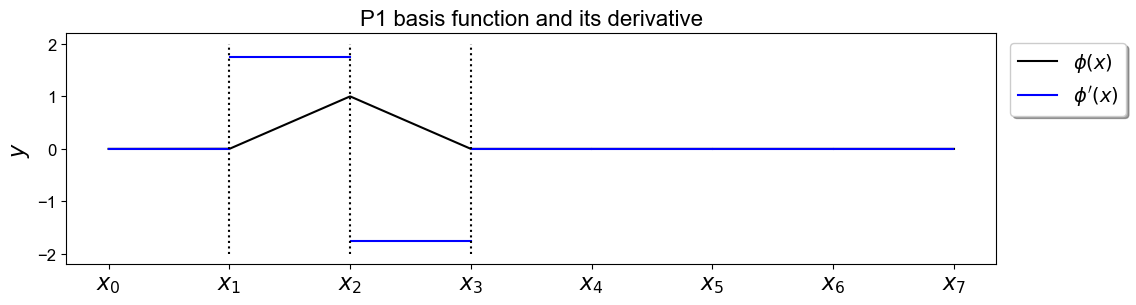

In [11]:
def hat_function_deriv(i, x_nodes):
    """ Derivative of linear continuous basis function at node i.
    Returns a function for later use in quadrature rules.
    """
    assert(i>=0 and i<=len(x_nodes)-1)
    dx = np.diff(x_nodes)
    if i==0:
        hat = lambda x: np.select([ x<=x_nodes[i+1] ], [ (-1)/dx[i] ] ,0.0)
    elif i==len(x_nodes)-1:
        hat = lambda x: np.select([ x>=x_nodes[i-1] ], [ (1)/dx[i-1] ] ,0.0)
    else:
        hat = lambda x: np.select(
                [ np.all([[x>=x_nodes[i-1]],[x<=x_nodes[i]]], axis=0)[0],  
                  np.all([[x>=x_nodes[i]],[x<=x_nodes[i+1]]], axis=0)[0]] ,
                [ (1)/dx[i-1], (-1)/dx[i] ] ,0.0)
    return hat

x_nodes = np.linspace(0,4,8)

# the following would give you a variable mesh!
#x_nodes = x_nodes + ((x_nodes[-1]-x_nodes[0])/5)*np.random.rand(len(x_nodes))

x_fine = np.linspace(0,4,1000)

fig = plt.figure(figsize=(12, 3))
ax1 = fig.add_subplot(111)
ax1.set_xticks((x_nodes))
ax1.set_xticklabels(('$x_0$','$x_1$','$x_2$','$x_3$','$x_4$','$x_5$','$x_6$','$x_7$' ), 
                    fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
ax1.set_title('P1 basis function and its derivative', fontsize=16)

# you can change the following to be in [0,n]
node = 2
phi = hat_function(node, x_nodes)
ax1.plot(x_fine, phi(x_fine), 'k-',label='$\phi(x)$');
phi_x = hat_function_deriv(node, x_nodes)
for i in range(len(x_nodes)-1):
    ax1.plot(x_fine[(x_fine>x_nodes[i]) & (x_fine<x_nodes[i+1])], 
             phi_x(x_fine[(x_fine>x_nodes[i]) & (x_fine<x_nodes[i+1])]), 
             'b-',label="$\phi'(x)$" if i==0 else "")
ax1.plot([x_nodes[node-1],x_nodes[node-1]], [-2,2],'k:')
ax1.plot([x_nodes[node],x_nodes[node]], [-2,2],'k:')
ax1.plot([x_nodes[node+1],x_nodes[node+1]], [-2,2],'k:')
ax1.legend(loc="upper right", bbox_to_anchor=(1.15,1.0), shadow=True, ncol=1, fontsize=14)


The fact that the basis function derivatives that appear in the integrand are all constants over individual elements makes this discretisation matrix especially easy to evaluate. 

Let's consider an internal row $i$:

$$
\begin{align*}
K_{ii} 
&= \int_0^1 \phi_i'\, \phi_i' \,dx 
\\[10pt]
&= 
\int_{x_{i-1}}^{x_i} \phi_i'\, \phi_i' \,dx + \int_{x_{i}}^{x_{i+1}} \phi_i'\, \phi_i' \,dx
\\[10pt]
&= \int_{x_{i-1}}^{x_i} \frac{1}{\Delta x_{i-1}}\, \frac{1}{\Delta x_{i-1}} \,dx + \int_{x_{i}}^{x_{i+1}} \frac{-1}{\Delta x_{i}}\, \frac{-1}{\Delta x_{i}} \,dx
\\[10pt]
&= \int_{x_{i-1}}^{x_i} \frac{1}{\Delta x_{i-1}^2} \,dx + \int_{x_{i}}^{x_{i+1}} \frac{1}{\Delta x_{i}^2} \,dx
\\[10pt]
&= \frac{\Delta x_{i-1}}{\Delta x_{i-1}^2} + \frac{\Delta x_{i}}{\Delta x_{i}^2}
\\[10pt]
&= \frac{1}{\Delta x_{i-1}} + \frac{1}{\Delta x_{i}}.
\end{align*}
$$

Similarly,

$$
\begin{align*}
K_{i,i-1} 
&= \int_0^1 \phi_i'\, \phi_{i-1}' \,dx 
\\[10pt]
&= 
\int_{x_{i-1}}^{x_i} \phi_i'\, \phi_{i-1}' \,dx 
\\[10pt]
&= \int_{x_{i-1}}^{x_i} \frac{1}{\Delta x_{i-1}}\, \frac{-1}{\Delta x_{i-1}} \,dx 
\\[10pt]
&= \int_{x_{i-1}}^{x_i} \frac{-1}{\Delta x_{i-1}^2} \,dx 
\\[10pt]
&= \frac{-1}{\Delta x_{i-1}},
\end{align*}
$$

and

$$
\begin{align*}
K_{i,i+1} 
&= \int_0^1 \phi_i'\, \phi_{i+1}' \,dx 
\\[10pt]
&= 
\int_{x_{i}}^{x_{i+1}} \phi_i'\, \phi_{i+1}' \,dx 
\\[10pt]
&= \int_{x_{i}}^{x_{i+1}} \frac{-1}{\Delta x_{i}}\, \frac{1}{\Delta x_{i}} \,dx 
\\[10pt]
&= \int_{x_{i}}^{x_{i+1}} \frac{-1}{\Delta x_{i}^2} \,dx 
\\[10pt]
&= \frac{-1}{\Delta x_{i}}.
\end{align*}
$$

Now consider the case $i=0$:

$$
\begin{align*}
K_{0,0} 
&= \int_0^1 \phi_0'\, \phi_0' \,dx 
\\[10pt]
&= 
\int_{x_{0}}^{x_1} \phi_0'\, \phi_0' \,dx \\[10pt]
&= \int_{x_{0}}^{x_1} \frac{-1}{\Delta x_{0}}\, \frac{-1}{\Delta x_{0}} \,dx 
\\[10pt]
&= \int_{x_{0}}^{x_1} \frac{1}{\Delta x_{0}^2} \,dx \\[10pt]
&= \frac{1}{\Delta x_{0}},
\end{align*}
$$

and 

$$
\begin{align*}
K_{0,1} 
&= \int_0^1 \phi_0'\, \phi_{1}' \,dx 
\\[10pt]
&= 
\int_{x_{0}}^{x_{1}} \phi_0'\, \phi_{1}' \,dx 
\\[10pt]
&= \int_{x_{0}}^{x_{1}} \frac{-1}{\Delta x_{0}}\, \frac{1}{\Delta x_{0}} \,dx 
\\[10pt]
&= \int_{x_{0}}^{x_{1}} \frac{-1}{\Delta x_{0}^2} \,dx 
\\[10pt]
&= \frac{-1}{\Delta x_{0}},
\end{align*}
$$

which by symmetry is that same as $K_{1,0}$. 

The entries for the $i=n$ row are defined similarly in terms of $\Delta x_n$.



Let's construct an example of the $K$ matrix, and compare to the mass matrix:

In [12]:
N_elements_CG = 5
N_nodes_CG = N_elements_CG + 1

x_nodes = np.linspace(0, 1 , N_nodes_CG )
dx = np.diff(x_nodes)

K = np.zeros((N_nodes_CG, N_nodes_CG ))

K[1:-1,1:-1] = np.diag(1. / dx[:-1]  +  1. / dx[1:] , k=0) - \
    np.diag(1. / dx[1:-1]   , k=-1) - np.diag(1. / dx[1:-1]   , k=1)
# add in the top row entries
K[0,0] = 1. / dx[0]
K[0,1] = -1. / dx[0]
K[1,0] = -1. / dx[0]
# add in the bottom row entries
K[-1,-1] = 1. / dx[-1]
K[-1,-2] = -1. / dx[-1]
K[-2,-1] = -1. / dx[-1]

print('K = ')
print(K)

# compare to the mass matrix
%precision 3
print('\nM= ')
print(mass_matrix(x_nodes))

K = 
[[ 5. -5.  0.  0.  0.  0.]
 [-5. 10. -5.  0.  0.  0.]
 [ 0. -5. 10. -5.  0.  0.]
 [ 0.  0. -5. 10. -5.  0.]
 [ 0.  0.  0. -5. 10. -5.]
 [ 0.  0.  0.  0. -5.  5.]]

M= 
[[0.067 0.033 0.    0.    0.    0.   ]
 [0.033 0.133 0.033 0.    0.    0.   ]
 [0.    0.033 0.133 0.033 0.    0.   ]
 [0.    0.    0.033 0.133 0.033 0.   ]
 [0.    0.    0.    0.033 0.133 0.033]
 [0.    0.    0.    0.    0.033 0.067]]


## A simple problem with homogeneous Dirichlet BCs

Now let's complete the description of our problem through the addition of some boundary conditions - our problem is not well-posed (we cannot solve it) without the addition of appropriate BCs.

### Problem description

Find $u\equiv u(x)$ which satisfies the ODE over the interval $[0,1]$

$$-u'' = f,$$

for a given source term $\,f$, with homogeneous Dirichlet boundary conditions:

$$ u(0) = u(1) = 0.$$

Physically we can interpret this as the steady state solution to a diffusion problem with a source given by $f$ and the solution "clamped" at the value zero at the ends of the domain.

To begin let's consider the problem with $f\equiv 1$ which with these BCs has the exact solution $u=-x(x-1)/2$.

### Finite element approximation

For this version of the problem (i.e. with Dirichlet boundary conditions) we have to make a few changes to what we did above for the generic case with no boundary conditions.

In the case of Dirichlet BCs we know the value of the solution at the ends of the domain, and so we do not need to solve for the discrete values $u_0$ and $u_N$.

Furthermore, since these take the values zero in this case
the approximate solution we substitute into our weak form is therefore 

$$u_h := \sum_{j=1}^{N-1} u_j\,\phi_j,$$

[we've dropped the first and last terms in the summation that we know are zero - a consequence is that our approximate solution only has $N-1$ free parameters].

Said another way, we look for a solution to our problem in the space of p/w linear functions which are zero at the boundaries:

$$V_h^0 := \left\{v \in V_h \,|\, v(0)=v(1)=0\right\}.$$

In our weak form we test against all $v\in V_h^0$, and since all these $v$ vanish at the boundary
this justified why in this case we can simply ignore the boundary term in our weak form (i.e. 
$\int_{\partial I} u_h'\,v\,dx = 0$) and thus we have:

$$\int_I \,u_h'\,v'\,dx = \int_I \,f\,v\,dx, \quad \forall v\in V_h^0.$$

We can again equivalently instead consider basis functions and ask that our solution satisfies

$$\int_0^1 u_h'\,\phi_i' \,dx = \int_0^1 f\,\phi_i \,dx, \;\;\;\;\; \text{for}\;\;\;\; i=1, 2,\ldots, N-1, $$

where now $i$ ranges over 2 less values (as $V_h^0$ is now $N-1$ rather than $N+1$ dimensional on our mesh).

[This is equivalent to the so-called "lifting" approach for imposing BCs we saw earlier].

Substituting in our form for our numerical solution again leads us to the matrix system

$$K\boldsymbol{u} = \boldsymbol{b},$$

where $K$ and $\boldsymbol{b}$ are defined as before, but without the first and last rows and columns (for $A$) we had previously.


In [13]:
# don't need the composite version of Simpson's rule here - 
# use the non composite version that is able to integrate over a 
# **single** interval and evaluates the function
# at the two end points as well as the mid point
def simpsons_rule(a, b, function, number_intervals=10):
    """ Function to evaluate Simpson's rule. 
    
    Note that this implementation takes the function as an argument, 
    and evaluates this at the midpoint of subintervals in addition to the 
    end point. Hence additional information is generated and used through 
    additional function evaluations. 
    
    This is different to the function/implementation available with SciPy  
    where discrete data only is passed to the function. 
    
    Bear this in mind when comparing results - there will be a factor of two
    in the definition of "n" we need to be careful about!
    
    Also note that this version of the function performs redundant function 
    evaluations - see the **composite** implementation.
    """

    interval_size = (b - a)/number_intervals

    assert interval_size > 0
    assert type(number_intervals) == int

    I_S = 0.0

    # Loop to valuate Simpson's formula over each interval 
    for i in range(number_intervals):
        # Find a, c, and b
        this_bin_start = a + interval_size * (i)
        this_bin_mid = this_bin_start + interval_size/2
        this_bin_end = this_bin_start + interval_size
        # Calculate the rule and add to running total.
        I_S += (interval_size/6) * (function(this_bin_start) +
                                  4 * function(this_bin_mid) + function(this_bin_end))

    # Return our running total result
    return I_S

In [14]:
# let's discretise and solve our problem using the FEM

def f(x):
    return 1.0

def u_exact(x):
    return -0.5*x*(x-1)

N_elements_CG = 9
N_nodes_CG = N_elements_CG + 1

x_nodes = np.linspace(0, 1 , N_nodes_CG )
dx = np.diff(x_nodes)

# space to store our discretisaton matrices
K = np.zeros((N_nodes_CG -2 , N_nodes_CG -2 ))

# we only need the internal entries of the K defined above in this case
K = np.diag(1. / dx[:-1]  +  1. / dx[1:] , k=0) \
    - np.diag(1. / dx[1:-1]   , k=-1) \
    - np.diag(1. / dx[1:-1]   , k=1)

# print out K to show that we've lost the first and last rows/columns 
# compared to the previous K we printed
print(K)

# form RHS vector by integrating the function f multiplied by a basis function.
# loop over internal nodes
RHS = np.zeros(N_nodes_CG - 2)
for node in range(1, N_nodes_CG - 1):
    # and integrate our function multiplied by the corresponding cts basis function  
    phi_i = hat_function(node, x_nodes)
    integrand = lambda x : f(x) * phi_i(x)
    # simpsons with number intervals = 2 can integrate this exactly
    RHS[node-1] = simpsons_rule(x_nodes[node-1], x_nodes[node+1], integrand, 2 )

# now we have our equation for the unknowns (K @ u=RHS) solve for u:
u = sl.solve(K,RHS)

[[18. -9.  0.  0.  0.  0.  0.  0.]
 [-9. 18. -9.  0.  0.  0.  0.  0.]
 [ 0. -9. 18. -9.  0.  0.  0.  0.]
 [ 0.  0. -9. 18. -9.  0.  0.  0.]
 [ 0.  0.  0. -9. 18. -9.  0.  0.]
 [ 0.  0.  0.  0. -9. 18. -9.  0.]
 [ 0.  0.  0.  0.  0. -9. 18. -9.]
 [ 0.  0.  0.  0.  0.  0. -9. 18.]]


error (RMS at nodes only) =  2.0525524970989362e-17


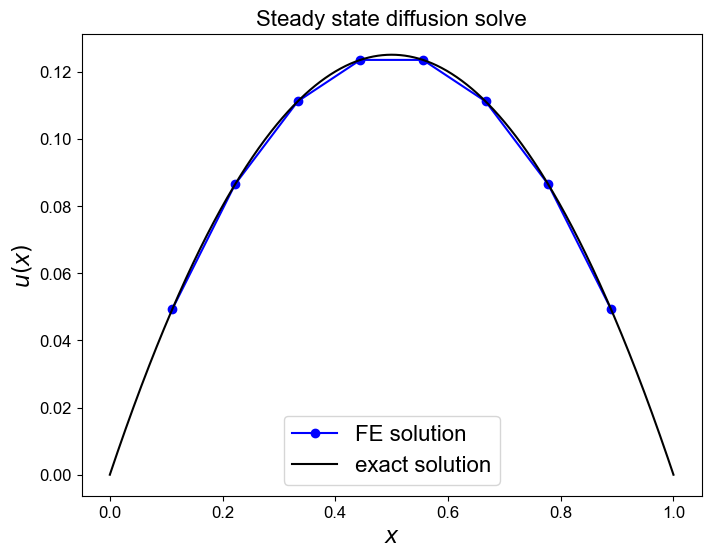

In [15]:
# plot the exact solution and our numerical approximation, 
# and print out the RMS error

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$u(x)$', fontsize=16)
ax1.set_title('Steady state diffusion solve', fontsize=16)
ax1.plot(x_nodes[1:-1], u, 'bo-', label='FE solution')
x_fine = np.linspace(0, 1, 1000)
ax1.plot(x_fine, -0.5*x_fine*(x_fine-1), 'k-', label='exact solution')
ax1.legend(loc='best', fontsize=16);

print('error (RMS at nodes only) = ', 
      sl.norm(u - (-0.5*x_nodes[1:-1]*(x_nodes[1:-1]-1)) )
      /np.sqrt(len(u)) )

### Comments

- We could of course add back in the fact that $u_h(0)=u_h(1)=0$ values to get a solution plot that extends all the way to the boundaries.


- Notice that we have obtained a solution in this case that is exact (to round off error) at the nodes. This is because we can evaluate the RHS vector exactly (i.e. no errors are introduced in this step) and also as our scheme is of high enough order to be able to integrate this problem exactly.


- But notice that the error is not zero when considered in the interior of elements - the more complex examples consider this point further.


<br>

Some more complex problems with non-zero RHS and/or more complex inhomogeneous Dirichlet/Neumann type BCs are covered in the homework notebook.

## Practical implementation of the FEM - local assembly over elements

## The underlying idea

When we formed the discretisation matrices in the examples we considered earlier (both the projection of a given function as well as the solution of BVPs examples), recall that we ***looped over the nodes*** and did an integral over the elements either side (in 1D, and apart from at boundaries).

These nodes corresponded with a particular trial function.

For each node we constructed the corresponding entry of the **load vector** by integrating using Simpson's rule the appropriate integral ($f\,\phi_i$) over the elements on each side of that node [in homework exercise].

<br>
In general we constructed the left hand side **discretisation matrix** directly (i.e. we wrote functions that used appropriate `np.diag` calls) using our analytical knowledge of the values of the required integrals (e.g. of $\phi_i\,\phi_j$ in the case of the mass matrix, and products of the derivatives of the basis functions in the BVP case), and the fact that they took a simple tridiagonal form. 

Recall that we did demonstrate through an application of Simpson's rule that quadrature rules were able to recreate our analytical result for the mass matrix (due to us being in 1D (hence simple shape) and integrating relatively low order polynomials).

<br>

However, note that this means of constructing the left hand side matrix won't be possible for more complex problems, and in the case of the load vector an approach of looping over nodes and then visiting each surrounding element won't be optimal in higher dimensions

<br> 

A far better approach, termed ***assembly*** or ***local assembly***, which addresses both issues is instead to loop ***over the elements*** visting each one just once, compute the required integrals only over that element, and *add* the appropriate results of these integrals into the appropriate locations of the global discretisation matrices.

<br>

To help clarify this idea let's consider the example of the mass matrix.

## Local assembly for the mass matrix

Recall that the mass matrix $M$ is defined to be the matrix with the entries

$$ M_{ij} = \int_\Omega \,\phi_i(x)\,\phi_j(x)\,  dx. $$

We noted that given the form of our basis functions (i.e. having finite compact support) that $M$ is *sparse* - for a given row, $i$,  the integrand in the definition above will be zero for all $j$ values other than $j=i$, and $j=i\pm 1$, i.e. the mass matrix is tridiagonal in 1D.

We demonstrated that an internal row (the $i$-th row) of the tridiagonal mass matrix has the entries

$$\left[0 \;\;\;\;\; \cdots \;\;\;\;\; 0 \;\;\;\;\; \frac{\Delta x_{i-1}}{6} \;\;\;\;\;  \frac{\Delta x_{i-1}}{3} + \frac{\Delta x_{i}}{3}  \;\;\;\;\; \frac{\Delta x_{i}}{6} \;\;\;\;\; 0 \;\;\;\;\; \cdots \;\;\;\;\;  0  \right], $$

with the first and last rows being

$$\left[\frac{\Delta x_{0}}{3}  \;\;\;\;\; \frac{\Delta x_{0}}{6} \;\;\;\;\; 0 \;\;\;\;\; \cdots \;\;\;\;\;  0  \right], $$

and

$$\left[0 \;\;\;\;\; \cdots \;\;\;\;\; 0 \;\;\;\;\; \frac{\Delta x_{n}}{6} \;\;\;\;\;  \frac{\Delta x_{n}}{3}\right]. $$


Combining we have

$$ M = 
\begin{pmatrix}
\frac{\Delta x_0}{3}  & \frac{\Delta x_0}{6} & & &  
\\
\frac{\Delta x_0}{6}  & \left(\frac{\Delta x_0}{3} + \frac{\Delta x_1}{3}\right) & \frac{\Delta x_1}{6} & &  \\
&\frac{\Delta x_1}{6}  & \left(\frac{\Delta x_1}{3} + \frac{\Delta x_2}{3}\right) & \frac{\Delta x_2}{6}  &  \\
&  &  \ddots & &  
\\
& &\frac{\Delta x_{n-1}}{6}  & \left(\frac{\Delta x_{n-1}}{3} + \frac{\Delta x_n}{3}\right) & \frac{\Delta x_n}{6}  \\
& &   &  \frac{\Delta x_n}{6} & \frac{\Delta x_n}{3}
\end{pmatrix}.
$$

Notice first that this is equivalent to [NB. I'm using notation that assumes that all entries not explicitly given in the presented matrices are zero]


$$ M = 
\begin{bmatrix}
\frac{\Delta x_0}{3} & \frac{\Delta x_0}{6} & &  \\
\frac{\Delta x_0}{6} & \frac{\Delta x_0}{3} & & \\ 
& & & \\
& & & \\
& & & \\
& & & 
\end{bmatrix} 
+
\begin{bmatrix}
& & & \\
& \frac{\Delta x_1}{3} & \frac{\Delta x_1}{6}  & \\ 
& \frac{\Delta x_1}{6} & \frac{\Delta x_1}{3}  &  \\
& & & \\
& & & \\
& & & 
\end{bmatrix} 
+ \ldots +
\begin{bmatrix}
& & & \\
& & & \\
& & & \\
& & & \\
& & \frac{\Delta x_n}{3} & \frac{\Delta x_n}{6} \\
& &\frac{\Delta x_n}{6}  & \frac{\Delta x_n}{3}  
\end{bmatrix},
$$

i.e. the global mass matrix is equivalent to the summation of ($n$, which is the number of elements) 
$2\times 2$ matrices which all take the form

$$\frac{1}{6}
\begin{bmatrix}
2 & 1\\
1 & 2
\end{bmatrix}{\Delta x_i}.
$$

Note that this smaller matrix only involves the size of element $i$, and as we shall see can be associated only with element $i$.  We therefore call it the ***local element mass matrix*** for element $i$.  Notice also that this same definition applies equally well to the first and last elements, i.e. we don't need to do anything special/different at boundaries (we will see that this is expected as we are dealing with each element in isolation, it's not important if it's next to the boundary or not).

Considering element $i$, we can see that the above $2\times 2$ sub-matrix block comes from the following contributions

$$
\begin{bmatrix}
\int_{e_i} \,\phi_i(x)\,\phi_i(x)\, dx     & \int_{e_i} \,\phi_i(x)\,\phi_{i+1}(x)\, dx \\
\int_{e_i} \,\phi_i(x)\,\phi_{i+1}(x)\, dx & \int_{e_i} \,\phi_{i+1}(x)\,\phi_{i+1}(x)\, dx
\end{bmatrix}
$$

where $e_i = [x_i,x_{i+1}]$ is the $i$-th element.

Note that when we sum up all these individual local mass matrices, each main diagonal (other than the first and last) will receive two contributions. Note that all that is happening here is what we saw analytically earlier when we integrated over the two elements either side of the node under consideration in order to derive an expression for the mass matrix.

To see that this makes sense another way, first we note that the total integral can be split up over elements:

$$
\begin{align*}
M_{ij} &= \int_\Omega \,\phi_i(x)\,\phi_j(x)\,  dx\\[5pt]
&= \sum_k\,\int_{e_k} \,\phi_i(x)\,\phi_j(x)\,  dx.
\end{align*}
$$

Then we note that most of the elemental contributions will be zero since the integrand will be zero over them. For example, for the diagonal entries we only have to consider

$$
\begin{align*}
M_{ii} 
& = \sum_k\,\int_{e_k} \,\phi_i(x)\,\phi_i(x)\,  dx\\[5pt]
& = \int_{e_{i-1}} \,\phi_i(x)\,\phi_i(x)\,  dx + \int_{e_{i}} \,\phi_i(x)\,\phi_i(x)\,  dx\\[5pt]
& = \int_{x_{i-1}}^{x_{i}} \,\phi_i(x)\,\phi_i(x)\,  dx + \int_{x_{i}}^{x_{i+1}} \,\phi_i(x)\,\phi_i(x)\,  dx\\[5pt]
& \; \vdots\\[5pt]
& = \frac{\Delta x_{i-1}}{3} + \frac{\Delta x_{i}}{3}.
\end{align*}
$$

<br>

The overall procedure underlying *local assembly* is therefore to


1. loop over elements


2. calculate the individual contributions to the local element mass matrix by considering combinations of the basis functions corresponding to the local node numbers (i.e. the four entries in the $2\times 2$ sub-matrix block above)


3. Identify the appropriate locations of the global mass matrix and *add* the current element's contributions to the values already in these locations


Note that for fully unstructured meshes in higher dimensions, there will be multiple contributions feeding into each entry of the global mass matrix (think multiple triangular elements surrounding a node/vertex).

Note also that exactly the same assembly procedure can be used to construct more complex discretisation matrices (e.g. the matrix $A$ in the BVP section) as well as the RHS load vectors.

## Example - projection

Let's demonstrate the assembly process through an example.

Recall our initial example from earlier where we "projected" a general function $\,f\,$ into the space of p/w linear functions.

First let's run our code from earlier which involved us defining the mass matrix analytically, and computing the RHS load vector through a **loop over nodes** (and evaluating the integrals on the elements either side to compute the nodal entry in one go) - an approach we just said isn't really a viable approach in higher dimensions.

In [16]:
# to do this we need our Simpson's quadrature codes

def simpsons_rule(a, b, function, number_intervals=10):
    """ Function to evaluate Simpson's rule. 
    
    Note that this implementation takes the function as an argument, 
    and evaluates this at the midpoint of subintervals in addition to the 
    end point. Hence additional information is generated and used through 
    additional function evaluations. 
    
    This is different to the function/implementation available with SciPy  
    where discrete data only is passed to the function. 
    
    Bear this in mind when comparing results - there will be a factor of two
    in the definition of "n" we need to be careful about!
    
    Also note that this version of the function performs redundant function 
    evaluations - see the **composite** implementation below.
    """

    interval_size = (b - a)/number_intervals

    assert interval_size > 0
    assert type(number_intervals) == int

    I_S = 0.0

    # Loop to valuate Simpson's formula over each interval 
    for i in range(number_intervals):
        # Find a, c, and b
        this_bin_start = a + interval_size * (i)
        this_bin_mid = this_bin_start + interval_size/2
        this_bin_end = this_bin_start + interval_size
        # Calculate the rule and add to running total.
        I_S += (interval_size/6) * (function(this_bin_start) +
                                  4 * function(this_bin_mid) + function(this_bin_end))

    # Return our running total result
    return I_S

def simpsons_composite_rule(a, b, function, number_intervals=10):
    """Function to evaluate the composite Simpson's rule only using
    function evaluations at (number_intervals + 1) points.
    
    This implementation requires that the number of subintervals (number_intervals) be even
    """
    assert number_intervals % 2 == 0, "number_intervals is not even"

    interval_size = (b - a) / number_intervals
    # start with the two end member values
    I_cS2 = function(a) + function(b)

    # add in those terms with a coefficient of 4
    for i in range(1, number_intervals, 2):
        I_cS2 += 4 * function(a + i * interval_size)

    # and those terms with a coefficient of 2
    for i in range(2, number_intervals-1, 2):
        I_cS2 += 2 * function(a + i * interval_size)

    return I_cS2 * (interval_size / 3.0)

The following is the code we wrote to set-up and solve the appropriate matrix system to yield the solution at the mesh vertices earlier - we repeat it here to give us something to verify our new approach/code against.

In [17]:
def f(x):
    return np.sin(2*np.pi*x) + 0.3*np.cos(3.*2.*np.pi*x**2)

# discrete data
N_nodes = 4
N_elements = N_nodes - 1
dx = 1./N_elements
x_nodes = np.linspace(0,1,N_nodes)

def mass_matrix(x):
    dx = np.diff(x)
    M = np.zeros((len(x), len(x)))
    M[1:-1,1:-1] = np.diag(dx[:-1]/3  +  dx[1:]/3 , k=0) 
    M += np.diag(dx/6   , k=-1) + np.diag(dx/6   , k=1)
    M[0,0] = dx[0]/3
    M[-1,-1] = dx[-1]/3
    return M

Mass_CG = mass_matrix(x_nodes)

# construct RHS vector
RHS_CG = np.zeros(N_nodes)

def hat_function(i, x_nodes):
    """ Top hat basis function at node i.
    Returns a function for later use in quadrature rules.
    """
    assert(i>=0 and i<=len(x_nodes)-1)
    dx = np.diff(x_nodes)
    if i==0:
        hat = lambda x: np.select([ x<=x_nodes[i+1] ], [ (x_nodes[i+1] - x)/dx[i] ] ,0.0)
    elif i==len(x_nodes)-1:
        hat = lambda x: np.select([ x>=x_nodes[i-1] ], [ (x - x_nodes[i-1])/dx[i-1] ] ,0.0)
    else:
        hat = lambda x: np.select(
                [ np.all([[x>=x_nodes[i-1]],[x<=x_nodes[i]]], axis=0)[0],  
                  np.all([[x>=x_nodes[i]],[x<=x_nodes[i+1]]], axis=0)[0]] ,
                [ (x-x_nodes[i-1])/dx[i-1], (x_nodes[i+1]-x)/dx[i] ] ,0.0)
    return hat


# loop over internal nodes

for node in range(1, N_nodes-1):
    # and integrate our function multiplied by the corresponding cts basis function
    phi_i = hat_function(node, x_nodes)
    integrand = lambda x : f(x) * phi_i(x)
    # simpsons with number intervals = 2 can integrate this exactly
    RHS_CG[node] = simpsons_rule(x_nodes[node-1], x_nodes[node+1], #
                                 integrand, 100 )
    
    
# now the end nodes
node = 0
# integrate our function multiplied by the corresponding cts basis function
phi_i = hat_function(node, x_nodes)
integrand = lambda x : f(x) * phi_i(x)
RHS_CG[node] = simpsons_composite_rule(x_nodes[node], x_nodes[node+1], 
                                       integrand, 50 )
node = N_nodes-1
# integrate our function multiplied by the corresponding cts basis function
phi_i = hat_function(node, x_nodes)
integrand = lambda x : f(x) * phi_i(x)
RHS_CG[node] = simpsons_composite_rule(x_nodes[node-1], x_nodes[node], integrand, 50 )

approx_CG = sl.solve(Mass_CG, RHS_CG)

print('Mass matrix =')
pprint(Mass_CG)
print('\nRHS vector =')
pprint(RHS_CG)

Mass matrix =
array([[0.111, 0.056, 0.   , 0.   ],
       [0.056, 0.222, 0.056, 0.   ],
       [0.   , 0.056, 0.222, 0.056],
       [0.   , 0.   , 0.056, 0.111]])

RHS vector =
array([ 0.137,  0.197, -0.199, -0.092])


Note that in the code above we looped over the nodes, and for the internal nodes computed the appropriate integral over the elements either side of the node in one go to compute the RHS vector, and we used our analytical function for the mass matrix.

<br>

Let's recode this using *local assembly* for both the mass matrix and the RHS vector, and check we get the same result.

We need to:


1. Loop over elements.


2. Loop over combinations of the local basis functions (giving the 4 entries of the $2\times 2$ elemental matrix).


3. Perform the quadratures only over the local element (to actually compute these 4 entries).


4. Add in the contributions to the appropriate locations of the global matrices/vectors.

## Unstructured mesh data structures (the connectivity matrix)

In order to know where the local contributions contribute to the global matrices, we make use of the so-called *connectivity matrix*.

It will seem a triviality in 1D, but it's vitally important in higher dimensions. We'll give the 2D generalisation later.

The following image presents a schematic of an unstructured mesh data structure, or connectivity, in the simple 1D case and assuming that we have two nodes per element (i.e. the p/w linear case), and that these are located at the ends of the elements (other more complex choices are possible!)

```{figure} Figures/connectivity_1d.svg
:width: 75%
```

- Blue are the *element numbers*


- Red are the *local node numbers* (as in local to that element)


- Black are the *global node numbers*


The connectivity can be described by the so-called connectivity matrix, which again in 1D takes the particularly simple form

$$
\begin{pmatrix}
    0 & 1 & \ldots & i-1 & i   & i+1 & \ldots & n \\
    1 & 2 & \ldots & i   & i+1 & i+2 & \ldots & n+1
\end{pmatrix}
$$

the column being the element, the row the local node number, and the entry of the matrix then being the global node number.

The size of the connectivity matrix is therefore: 

$$\text{the number of local nodes per element}\;\;\times\;\;\text{the number of elements},$$

and it provides a mapping from elements to global node numbers that we use to tell us where to add in the entries we compute over a local element into the global discretisation matrices.

In [18]:
# the connectivity matrix in 1D we need to use for this case.

# mesh information
N_nodes = 4
N_elements = N_nodes - 1
x_nodes = np.linspace(0,1,N_nodes)
dx = np.diff(x_nodes)

# number of nodes per element 
N_loc = 2

# the connectivity matrix giving us a mapping from local to global numbering
connectivity_matrix = np.zeros((N_loc, N_elements), dtype=int)
for element in range (N_elements):
    connectivity_matrix[0, element] = element
    connectivity_matrix[1, element] = element + 1
    
print(connectivity_matrix)

[[0 1 2]
 [1 2 3]]


Now let's write some code to perform assembly to compute both the mass matrix as well as the RHS load vector, and check that we get the same results as our previous implementation which returned

```Python
Mass matrix =
array([[0.11111111, 0.05555556, 0.        , 0.        ],
       [0.05555556, 0.22222222, 0.05555556, 0.        ],
       [0.        , 0.05555556, 0.22222222, 0.05555556],
       [0.        , 0.        , 0.05555556, 0.11111111]])

RHS vector =
array([ 0.13686339,  0.19747647, -0.1988013 , -0.0924463 ])
```

M = 
array([[0.111, 0.056, 0.   , 0.   ],
       [0.056, 0.222, 0.056, 0.   ],
       [0.   , 0.056, 0.222, 0.056],
       [0.   , 0.   , 0.056, 0.111]])

RHS = 
array([ 0.137,  0.197, -0.199, -0.092])

approx_CG = 
array([ 0.748,  0.967, -1.061, -0.302])


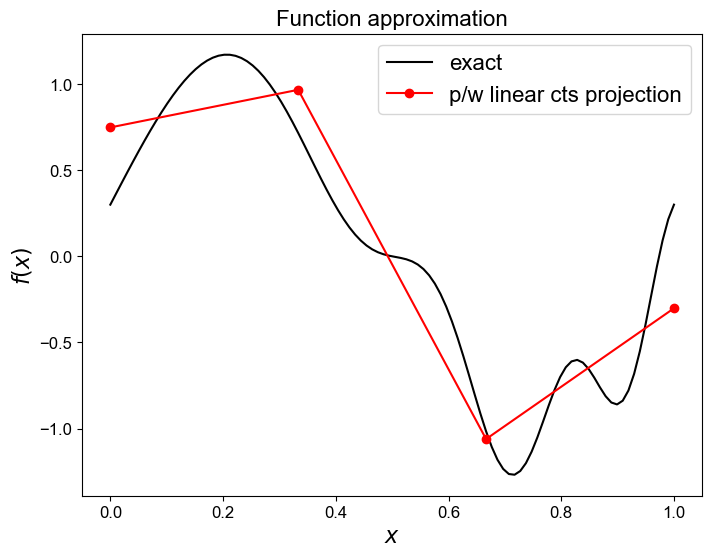

In [19]:
# project f(x) onto p/w linears using local assembly to form mass matrix and RHS load vector

def f(x):
    return np.sin(2*np.pi*x) + 0.3*np.cos(3.*2.*np.pi*x**2)
          
# construct mass matrix and RHS vector using **local assembly**

# initialise M to a zero array - we will **add** in the entries
M = np.zeros((N_nodes, N_nodes))
RHS = np.zeros(N_nodes)
# loop over elements
for element in range(N_elements):
    # loop over the LOCAL nodes (i: test functions)
    for i_local in range(N_loc):
        # for this local node number on this element, 
        # compute the corresponding global node number
        i_global = connectivity_matrix[i_local, element]
        # add contribution to RHS vector - 
        # these integrals will be explained in the next cell
        if(i_local == 0):
            integrand = lambda xi: f( (x_nodes[i_global] + 
                                       0.5*dx[element]) + 
                                     0.5*dx[element]*xi ) * 0.5*(1-xi)
        else:
            # here i_global corresponds to node i+1 so redefine x(xi) accordingly
            integrand = lambda xi: f( ((x_nodes[i_global]-dx[element]) + 0.5*dx[element]) 
                                     + 0.5*dx[element]*xi ) * 0.5*(1+xi)
        RHS[i_global] += 0.5*dx[element] * simpsons_composite_rule(
            -1, 1, integrand, 100 )
        # Now for the mass matrix
        # loop over local nodes (j: trial functions)
        for j_local in range(N_loc):
            j_global = connectivity_matrix[j_local, element]
            if(i_local == 0):
                if(j_local == 0):      
                    # again, these integrals will be explained properly in the next cell
                    integrand = lambda xi: 0.5*(1-xi) * 0.5*(1-xi)
                else:
                    integrand = lambda xi: 0.5*(1-xi) * 0.5*(1+xi)
            else:
                if(j_local == 0):           
                    integrand = lambda xi: 0.5*(1+xi) * 0.5*(1-xi)
                else:
                    integrand = lambda xi: 0.5*(1+xi) * 0.5*(1+xi)
            # add in the local contribution to the global mass matrix
            M[i_global,j_global] += 0.5*dx[element] * simpsons_rule(
                -1, 1, integrand, 1 )

print('M = ')       
pprint(M)
print('\nRHS = ')
pprint(RHS)

approx_CG = sl.solve(M, RHS)

print('\napprox_CG = ')
pprint(approx_CG)

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$f(x)$', fontsize=16)
ax1.set_title('Function approximation', fontsize=16)
# plot the exact function on a fine mesh
x_fine = np.linspace(0,1,100)
ax1.plot(x_fine, f(x_fine), 'k-', label = 'exact')
ax1.plot(x_nodes, approx_CG , 'ro-', label='p/w linear cts projection')
ax1.legend(loc='best', fontsize=16);

## Quadrature over the local element (change of variables to a reference element)


We've played one final trick in the implementation above.

It turns out that, especially in higher dimensions and for more complicated basis functions, that it is advantageous to transform our integrals over each individual element (which each could be a different shape and size) so that they are all performed over the same "reference" element.

Consider the schematic below.


```{figure} Figures/reference_elements_1d.svg
:width: 75%
```

<br>

The left part shows the mesh in the real physical coordinate we want to compute our solution over; the right shows the reference element we compute integrals over, with the mappings between the two also indicated.

## Transformation to the reference element

It is common to define the reference element in 1D to be either $\,e_\text{ref}:=[0,1]\,$ or $\,e_\text{ref}:=[-1,1]\,$.  

As per the schematic we shall choose the latter option.

We use $\,\xi\,$ as the notation of the coordinate over the reference element.

We can then define the linear mapping between the physical $\,x\in[x_L, x_R]\,$ and the reference element $\,\xi\in[-1,1]\,$ via

$$
\begin{align*} 
x &= \frac{1}{2}\left(x_L+x_R\right) + \frac{1}{2}\left(x_R - x_L\right)\xi \\[5pt]
&= \frac{1}{2}\left(x_L+x_R\right) + \frac{1}{2}\Delta x\,\xi.
\end{align*}
$$

where $\,\Delta x = x_R-x_L\,$ is the *local* mesh size.

Integrals over a physical element $\,e_i\,$ can then be computed as in the following example of a mass matrix entry:

$$
\begin{align*}
\int_{e_i} \,\phi_{i}(x)\,\phi_{i}(x)\, dx 
&\equiv 
\int_{x_i}^{x_{i+1}} \,\phi_{i}(x)\,\phi_{i}(x)\, dx \\[10pt]
& = 
\int_{-1}^{1} \,\phi_{i}(\xi)\,\phi_{i}(\xi)\, |J| \, d\xi\\[10pt]
& \equiv 
\int_{e_{\text{ref}}} \,\phi_{i}(\xi)\,\phi_{i}(\xi)\, |J| \, d\xi
\end{align*}
$$

where $|J|$ is the Jacobian determinant which we always need to remember to include when we perform a [*change of variables in an integral*](http://mathworld.wolfram.com/ChangeofVariablesTheorem.html).

In our case

$$ J = \frac{dx}{d\xi} = \frac{1}{2}\Delta x,$$

where $\Delta x$ is understood to be the local element size.

We need to consider how the basis functions $\phi_i$ and $\phi_{i+1}$ are defined in terms of the variable $\xi$, i.e. what they look like in the reference element. But this is simple as we know for linear basis functions they are 1 at one node, 0 at the other, and linear in between. The two basis functions on the reference element are therefore in the linear case simply

$$ \phi_0(\xi) := \frac{1}{2}( 1 - \xi),\;\;\;\;\;\;\;\; \phi_1(\xi) := \frac{1}{2}( 1 + \xi), $$

where the subscripts 0 and 1 refer to the *local* node number on the element.

These take a particularly simple form; this is one of the advantages of the reference element approach and extends to higher order elements. 

This is why in the code above we defined one of the integrands to be

> `integrand = lambda xi: 0.5*(1-xi) * 0.5*(1-xi)`

and multiplied through by half the element size after computing the integral of this over the interval $[-1,1]$:

> `M[i_global,j_global] += 0.5*dx[element] * simpsons_rule(-1, 1, integrand, 1 )`

and for the RHS vector why the source function argument takes the form:

> `f( (x_nodes[i_global] + 0.5*dx[element]) + 0.5*dx[element]*xi ) `

where we use the fact that $\frac{1}{2}\left(x_L+x_R\right)+ \frac{1}{2}\Delta x\,\xi= \left(x_L + \frac{1}{2}\Delta x\right) + \frac{1}{2}\Delta x\,\xi$.

### Aside: quadratic basis functions

As a further example let's consider what quadratic basis functions would look like, and how easily they can be defined, on the reference element:

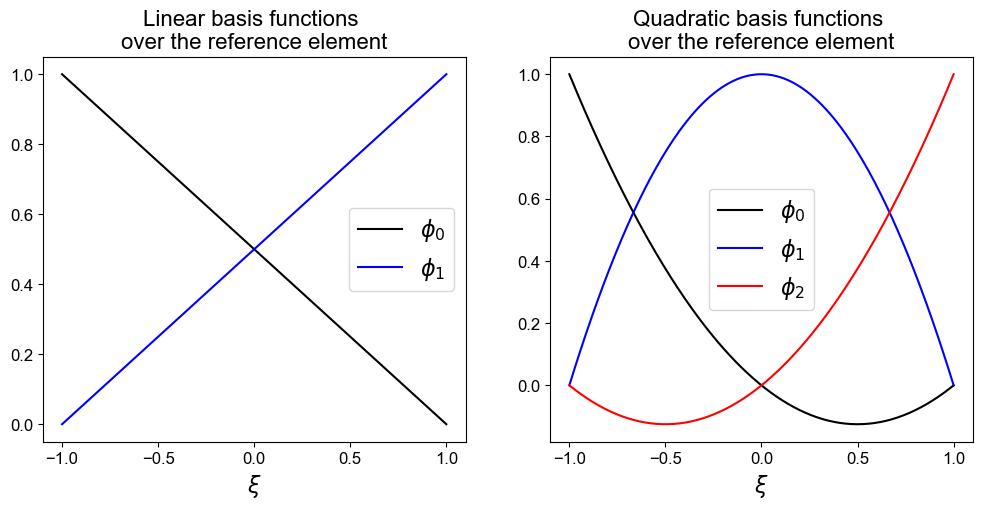

In [20]:
fig = plt.figure(figsize=(12, 5))
fig.tight_layout(w_pad=6, h_pad=6)
ax1 = fig.add_subplot(121)
ax1.set_xlabel(r'$\xi$', fontsize=16)
ax1.set_title('Linear basis functions \nover the reference element', 
              fontsize=16)
xi = np.linspace(-1, 1, 200)
# the two linear basis functions
ax1.plot(xi, 0.5*(1-xi), 'k-', label='$\phi_0$')
ax1.plot(xi, 0.5*(1+xi), 'b-', label='$\phi_1$')
ax1.legend(loc='best', fontsize=16)

ax1 = fig.add_subplot(122)
ax1.set_xlabel(r'$\xi$', fontsize=16)
ax1.set_title('Quadratic basis functions \nover the reference element', 
              fontsize=16)
xi = np.linspace(-1, 1, 200)
# the three quadratic basis functions
ax1.plot(xi, 0.5*(xi-1)*xi, 'k-', label='$\phi_0$')
ax1.plot(xi, 1 - xi**2, 'b-', label='$\phi_1$')
ax1.plot(xi, 0.5*(xi+1)*xi, 'r-', label='$\phi_2$')
ax1.legend(loc='best', fontsize=16)

**The mass matrix**

Following through the example case of the mass matrix and p/w linear basis functions we have

$$
\begin{align*}
\int_{e_i} \,\phi_{i}(x)\,\phi_{i}(x)\, dx 
&\equiv 
\int_{x_i}^{x_{i+1}} \,\phi_{i}(x)\,\phi_{i}(x)\, dx \\[10pt]
& = 
\int_{-1}^{1} \,\phi_{0}(\xi)\,\phi_{0}(\xi)\, |J| \, d\xi\\[10pt]
& = \int_{-1}^{1} \, \frac{1}{2}( 1 - \xi) \, \frac{1}{2}( 1 - \xi) \, \frac{\Delta x_i}{2} \, d\xi
\\[10pt]
& = \frac{\Delta x_i}{8} \int_{-1}^{1} \, ( 1 - \xi)^2 \,  d\xi
\\[10pt]
& = \frac{\Delta x_i}{8} \left[ -\frac{1}{3}( 1 - \xi)^3 \right]_{-1}^{1}
\\[10pt]
& = \frac{\Delta x_i}{8} \left[ -\frac{1}{3}( 1 - 1)^3  + \frac{1}{3}( 1 - (-1))^3\right]
\\[10pt]
& = \frac{\Delta x_i}{3}, 
\end{align*}
$$

which agrees with what we've computed before (which of course it should do!). 

The other entries we need follow similarly:

$$
\int_{e_i} \,\phi_{i+1}(x)\,\phi_{i+1}(x)\, dx =  \frac{\Delta x_i}{3},
$$

$$
\int_{e_i} \,\phi_{i}(x)\,\phi_{i+1}(x)\, dx =  \frac{\Delta x_i}{6}.
$$


**The load vector**

For contributions to the load vector of the form

$$ \int_{e_{i}}\,f(x)\,\phi_i(x)\, dx \equiv \int_{x_{i}}^{x_{i+1}} \,f(x)\,\phi_i(x)\, dx,$$

we actually compute over the reference element the following

$$
\begin{align*} 
\int_{x_{i}}^{x_{i+1}} \,f(x)\,\phi_i(x)\, dx
& = \int_{-1}^{1} \,f(x(\xi))\,\phi_0(\xi)\, \frac{\Delta x}{2} \, d\xi \\[10pt]
& = \frac{\Delta x}{2}
\int_{-1}^{1} \,f\left( \frac{1}{2}\left(x_L+x_R\right) + \frac{1}{2}\Delta x\,\xi \right) \,\frac{1}{2}( 1 - \xi) \, d\xi,
\end{align*}
$$
where $\phi_0$ refers to the "first" basis function **on the reference element** (over element $e_i$ it would be $\phi_{i+1}(x)$ that corresponds to the local basis function $\phi_1(\xi)$).
$$

## Local assembly for integrands that involve derivatives

So now we know how to assemble the contributions which feed into the mass matrix and the RHS load vector.

The final issue we need to consider is how to deal with derivatives of basis functions. 

For example, from the BVP section earlier we know that we needed to consider integrals of the form

$$\int_0^1 \phi_j'\, \phi_i' \,dx,$$

where 

$$\phi_i' \equiv \frac{d}{dx}\phi_i(x).$$

When transformed to the reference element we are therefore going to need to evaluate the $x$ derivative of the transformed basis functions, e.g. 

$$\frac{d}{dx}\phi_0(\xi) 
\;\;\;\;\;\;\; \text{where}\;\;\;\;\; \;\;\; 
\phi_0(\xi):=\frac{1}{2}( 1 - \xi).$$

How do we do this?  Via the chain rule:

$$\frac{d}{dx}\phi_0(\xi) = \frac{d}{d\xi}\phi_0(\xi)\, \frac{d\xi}{dx} = \phi'_0(\xi)\, \frac{d\xi}{dx},$$

and we know that 

$$ \frac{d\xi}{dx} = \left( \frac{dx}{d\xi} \right)^{-1} = \frac{2}{\Delta x}
\qquad\text{as}\quad 
x = \frac{1}{2}\left(x_L+x_R\right) + \frac{1}{2}\Delta x\,\xi,
$$

and for our linear basis functions

$$\phi'_0(\xi) = -\frac{1}{2}\;\;\;\;\;\;\;\; \text{and}\;\;\;\;\;\;\;\; 
\phi'_1(\xi) = \frac{1}{2}.$$


In higher dimensions we have something similar, we just need to make use of the Jacobian matrix.


## Using the FEM to solve time-dependent PDEs

Whether or not we use the local assembly approach, or the first approach we encountered for BVPs, to construct the discretisation matrices,
we now have all we need to implement a FEM based solver for pretty much any PDE in any spatial dimension.

<br>

But how do we deal with time-dependent problems, i.e. with time derivatives?

<br>

Consider time-dependent diffusion written in the form 

$$\frac{\partial u}{\partial t} = \kappa\frac{\partial^2 u}{\partial x^2}, $$

and assuming for simplicity that the diffusivity $\kappa$ is constant.

The weak/variational form of this problem can be written as (ignoring boundary terms)

$$ \int_I \,\frac{\partial u}{\partial t}\,v\,dx + \kappa\int_I \,u'\,v'\,dx = 0, \;\;\;\;\forall \;\; v\in V.$$

Substituting in our approximate solution function 

$$u_h(x,t) := \sum_{j=0}^{n} u_j(t)\,\phi_j(x),$$

and restricting the test functions to the appropriate finite-dimensional space ($v\in V_h$ with a basis given by $\phi_i$) yields the discrete system

$$
\begin{align*} 
\sum_{j=0}^{n} \,\frac{\partial u_j}{\partial t}\, \int_0^1 \phi_j\, \phi_i \,dx  +  \kappa\sum_{j=0}^{n} u_j\, \int_0^1 \phi_j'\, \phi_i' \,dx &= 0\;\;\;\;\; \text{for}\;\;\;\; i = 0, 1,\ldots, n \\[10pt]
\iff
\sum_{j=0}^{n} \,\frac{d u_j}{d t} M_{ij} + \kappa\sum_{j=0}^{n} u_j\, K_{ij} &= 0, \;\;\;\;\; \text{for}\;\;\;\; i = 0, 1,\ldots, n.
\end{align*}
$$

Or in matrix form

$$
M\, \frac{d \boldsymbol{u}}{d t} + \kappa\, K\,\boldsymbol{u} = \boldsymbol{0},
$$

where $K$ is the discretisation matrix for diffusion we saw previously, and $M$ is the mass matrix. Note that at this stage we have semi-discretised in space using the "method of lines" approach we saw previously when solving PDEs using the FDM.

To discretise in time we simply replace the time derivative with a finite difference approximation (or indeed any of the range of ODE solvers/libraries we have seen). 

Suppose we want to implement the "theta" method (to give us the flexibility to choose forward Euler, backward Euler or Crank-Nicolson), then we have to consider the system

$$
M \,\frac{\boldsymbol{u}^{n+1} - \boldsymbol{u}^{n}}{\Delta t} + \kappa\, K\,\left(\theta \left(\boldsymbol{u}^{n+1} + (1-\theta)\boldsymbol{u}^{n}\right)\right) = \boldsymbol{0},
$$

which can be rearranged to 

$$ \left( M + \theta\,\Delta t \,\kappa\, K \right)  \boldsymbol{u}^{n+1} = \left( M - (1-\theta)\, \Delta t \,\kappa\, K \right) \boldsymbol{u}^{n}.$$

<br>

But this is just a matrix system for the solution at the new time level we can solve using linear solvers.


## Higher dimensions and unstructured meshes

In 1D we could form a basis for the space of piecewise linear continuous functions, from "hat" (or "tent") functions that take the value unity at a single node, and are zero at all others, e.g.:

```{figure} Figures/hat-function-1d.png
:width: 50%
```

In two dimension we do exactly the same. This is what it looks like:

```{figure} Figures/hat-function-2d.svg
:width: 50%
```

<sup>**[source](http://brickisland.net/cs177/?p=309)**</sup>

As you can see the basis function $\phi_i$ is 1 at the node $i$ and linearly decreases to 0 over the adjacent triangles. Anywhere else $\phi_i$ is 0. 

Just like in 1D, we can write any piecewise linear function as a linear combination of such basis functions:

$$f_h(x) = \sum_{i=0}^N \alpha_i \phi_i(x). $$

It is also possible to allow for higher degree polynomials. For piecewise *quadratic* polynomials, we need the function value at six locations in each triangle. A common choice is to use the same three vertices of the triangle as with p/w linears, as well as three additional nodes located at the middle of each edge.

We can also choose to allow polynomials that are *discontinous* between adjacent triangles. The "hat" basis functions displayed above are continuous, and thus the linear combination of these are continuous as well. By choosing basis functions that are nonzero over a single triangle only, i.e. it takes the value of one at one vertex *inside* the triangle, but jumps to zero immediately outside the triangle, we can form discontinuous functions as well. The choice between continuous and discontinuous basis functions leads to the so-called Continuous Galerkin (CG) and Discontinuous Galerkin (DG) methods

<img src="https://mathstats.uncg.edu/applied/wp-content/uploads/sites/2/2018/01/DG_CG_edit.jpg">

<sup>**[source](https://mathstats.uncg.edu/applied/wp-content/uploads/sites/2/2018/01/DG_CG_edit.jpg)**</sup>

<br>

Finally, we should note that we do not *have to* use triangular (or tetrahedral in 3D) meshes for the FEM. Quadrilateral meshes are another possibility where we can for instance choose piecewise *bilinear* basis functions.  In practice we can use any shape element as long as we can represent the appropriate 
basis functions and perform integrals over that shape with ease.  


## Final comments

That might have all seemed like a lot of work (to essentially arrive at something not completely  dis-similar to what FDM could do) with a lot of additional steps and computational overhead (e.g. all those quadratures we did not need with FDM).


The power of the FEM really comes into play when


1. we move to higher dimensions, and/or


2. we use more exotic basis functions, and/or


3. we want to make use of some of the theoretical properties that can be established with the FEM, e.g. rigorous error estimators that can be used to guide adaptive mesh algorithms to achieve accuracy and efficiency.

<br>

An important final thing for you to understand is how we would go about discretising more complex equations - to help with this a homework questions asks you to consider the problem $u''+u=f$.

## The perodic table of finite elements

```{figure} Figures/femtable.png
:width: 75%
```

for more details see <http://www-users.math.umn.edu/~arnold/femtable/>